In [460]:
#----------a plotting function, dont think i use it anymore---------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.qaoa.models.MaxCutProblem import MaxCutProblem

def visualize(data, x,y, hues, chart):
    fig = plt.figure(figsize=(8,6))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
        case None:
            chart_type = sns.plot

    # make a copy to avoid modifying the original DataFrame and avoid warnings
    data_to_plot = data.copy()

    try:
        if len(hues) > 1:
            data_to_plot['hues'] = data_to_plot[hues].astype(str).agg('-'.join, axis=1)
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        elif len(hues) == 1:
            data_to_plot['hues'] = data_to_plot[hues[0]]
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            _ = chart_type(data=data_to_plot, x=x, y=y)
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
            #plt.show()

            plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

        plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
        plt.show()
        plt.close(fig)
    except (KeyError, ValueError) as e:
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data_to_plot.columns}\nException: {e}")


### Configure the check_data you want to visualize under.

#### Pick multiple hues with ctrl or shift + click.
#### The "Exclude bad" removes the warm started hamming distances of >0 from the dataset.


In [461]:
#-------------- load and clean data------------------
import ast
import numpy as np
import json
from src.qaoa.models.solver import MinVertexCoverSolver
import networkx as nx


strings = [
"results/results_noisy_P_147_vanilla.csv",
"results/results_statevector_HD135_all.csv"]

""",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'multiangle'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
]
"""
strings_lagrange = ["results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{True},'problem_type'{'minvertexcover'},'lagrangian_multiplier.csv",
"results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{False,True},'problem_type'{'minvertexcover'},'lagrangian_mult.csv"
   ]
 

for file in strings:
    try:
        df = pd.read_csv(file)
        #print(f"File: {file}")
        #print(df['graph_name'].value_counts())
        #print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path,index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0])



for file in strings_lagrange:
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings_lagrange) >1:
    results_lagrange = pd.concat([pd.read_csv(path,index_col=0) for path in strings_lagrange])

else:
    results_lagrange = pd.read_csv(strings_lagrange[0])

results_lagrange = results_lagrange[((results_lagrange['qaoa_variant'] == 'multiangle') & (results_lagrange['depth'] == 1)) |
              ((results_lagrange['qaoa_variant'] == 'vanilla') & (results_lagrange['depth'] == 4))]
results['depth'] = results['depth'].astype(int)
results_lagrange['depth'] = results_lagrange['depth'].astype(int)

problem = MaxCutProblem()

new_sparse = pd.read_csv("results_rerun_sparse_statevector.csv")
results.reset_index(inplace=True)
print(len(results))
old_sparse = results[(results['graph_name']=='>>graph6<<Hh_iS_u')&
                     (results['backend_mode']=='statevector')& (results['warm_start']==False)]
print(len(old_sparse))
print(len(new_sparse))
results.drop(index=old_sparse.index, inplace=True)
print(len(results))

results = pd.concat([results, new_sparse], ignore_index=True)
print(len(results))

graphs = problem.get_erdos_renyi_graphs_paper1()
for g in graphs:
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results['graph_name'] == graph6_string
    results.loc[results['graph_name'] == graph6_string, 'infeasible']= results.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results['graph_name'] == graph6_string) & (results['warm_start'] == True)
    results.loc[mask_ws, 'ws_value'] = results.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )
    
for g in graphs: #lagrange version
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results_lagrange['graph_name'] == graph6_string
    results_lagrange.loc[mask, 'infeasible']= results_lagrange.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results_lagrange['graph_name'] == graph6_string) & (results_lagrange['warm_start'] == True)
    results_lagrange.loc[mask_ws, 'ws_value'] = results_lagrange.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )
results.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
results_lagrange.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)



print('Results contain all statevector data and noisy data of vanilla p1 -> 7.\n'
'Lagrangian contains only ideal and ma p = 1 and V p = 4.  \n' \
'Infeasible column added, and depth converted to int.\n'
'Renamed quantum_func_evals to Iterations.\n'
'Updated sparse data with rerun results.\n')

10998
400
400
10598
10998
Results contain all statevector data and noisy data of vanilla p1 -> 7.
Lagrangian contains only ideal and ma p = 1 and V p = 4.  
Infeasible column added, and depth converted to int.
Renamed quantum_func_evals to Iterations.
Updated sparse data with rerun results.



C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\3464878749.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


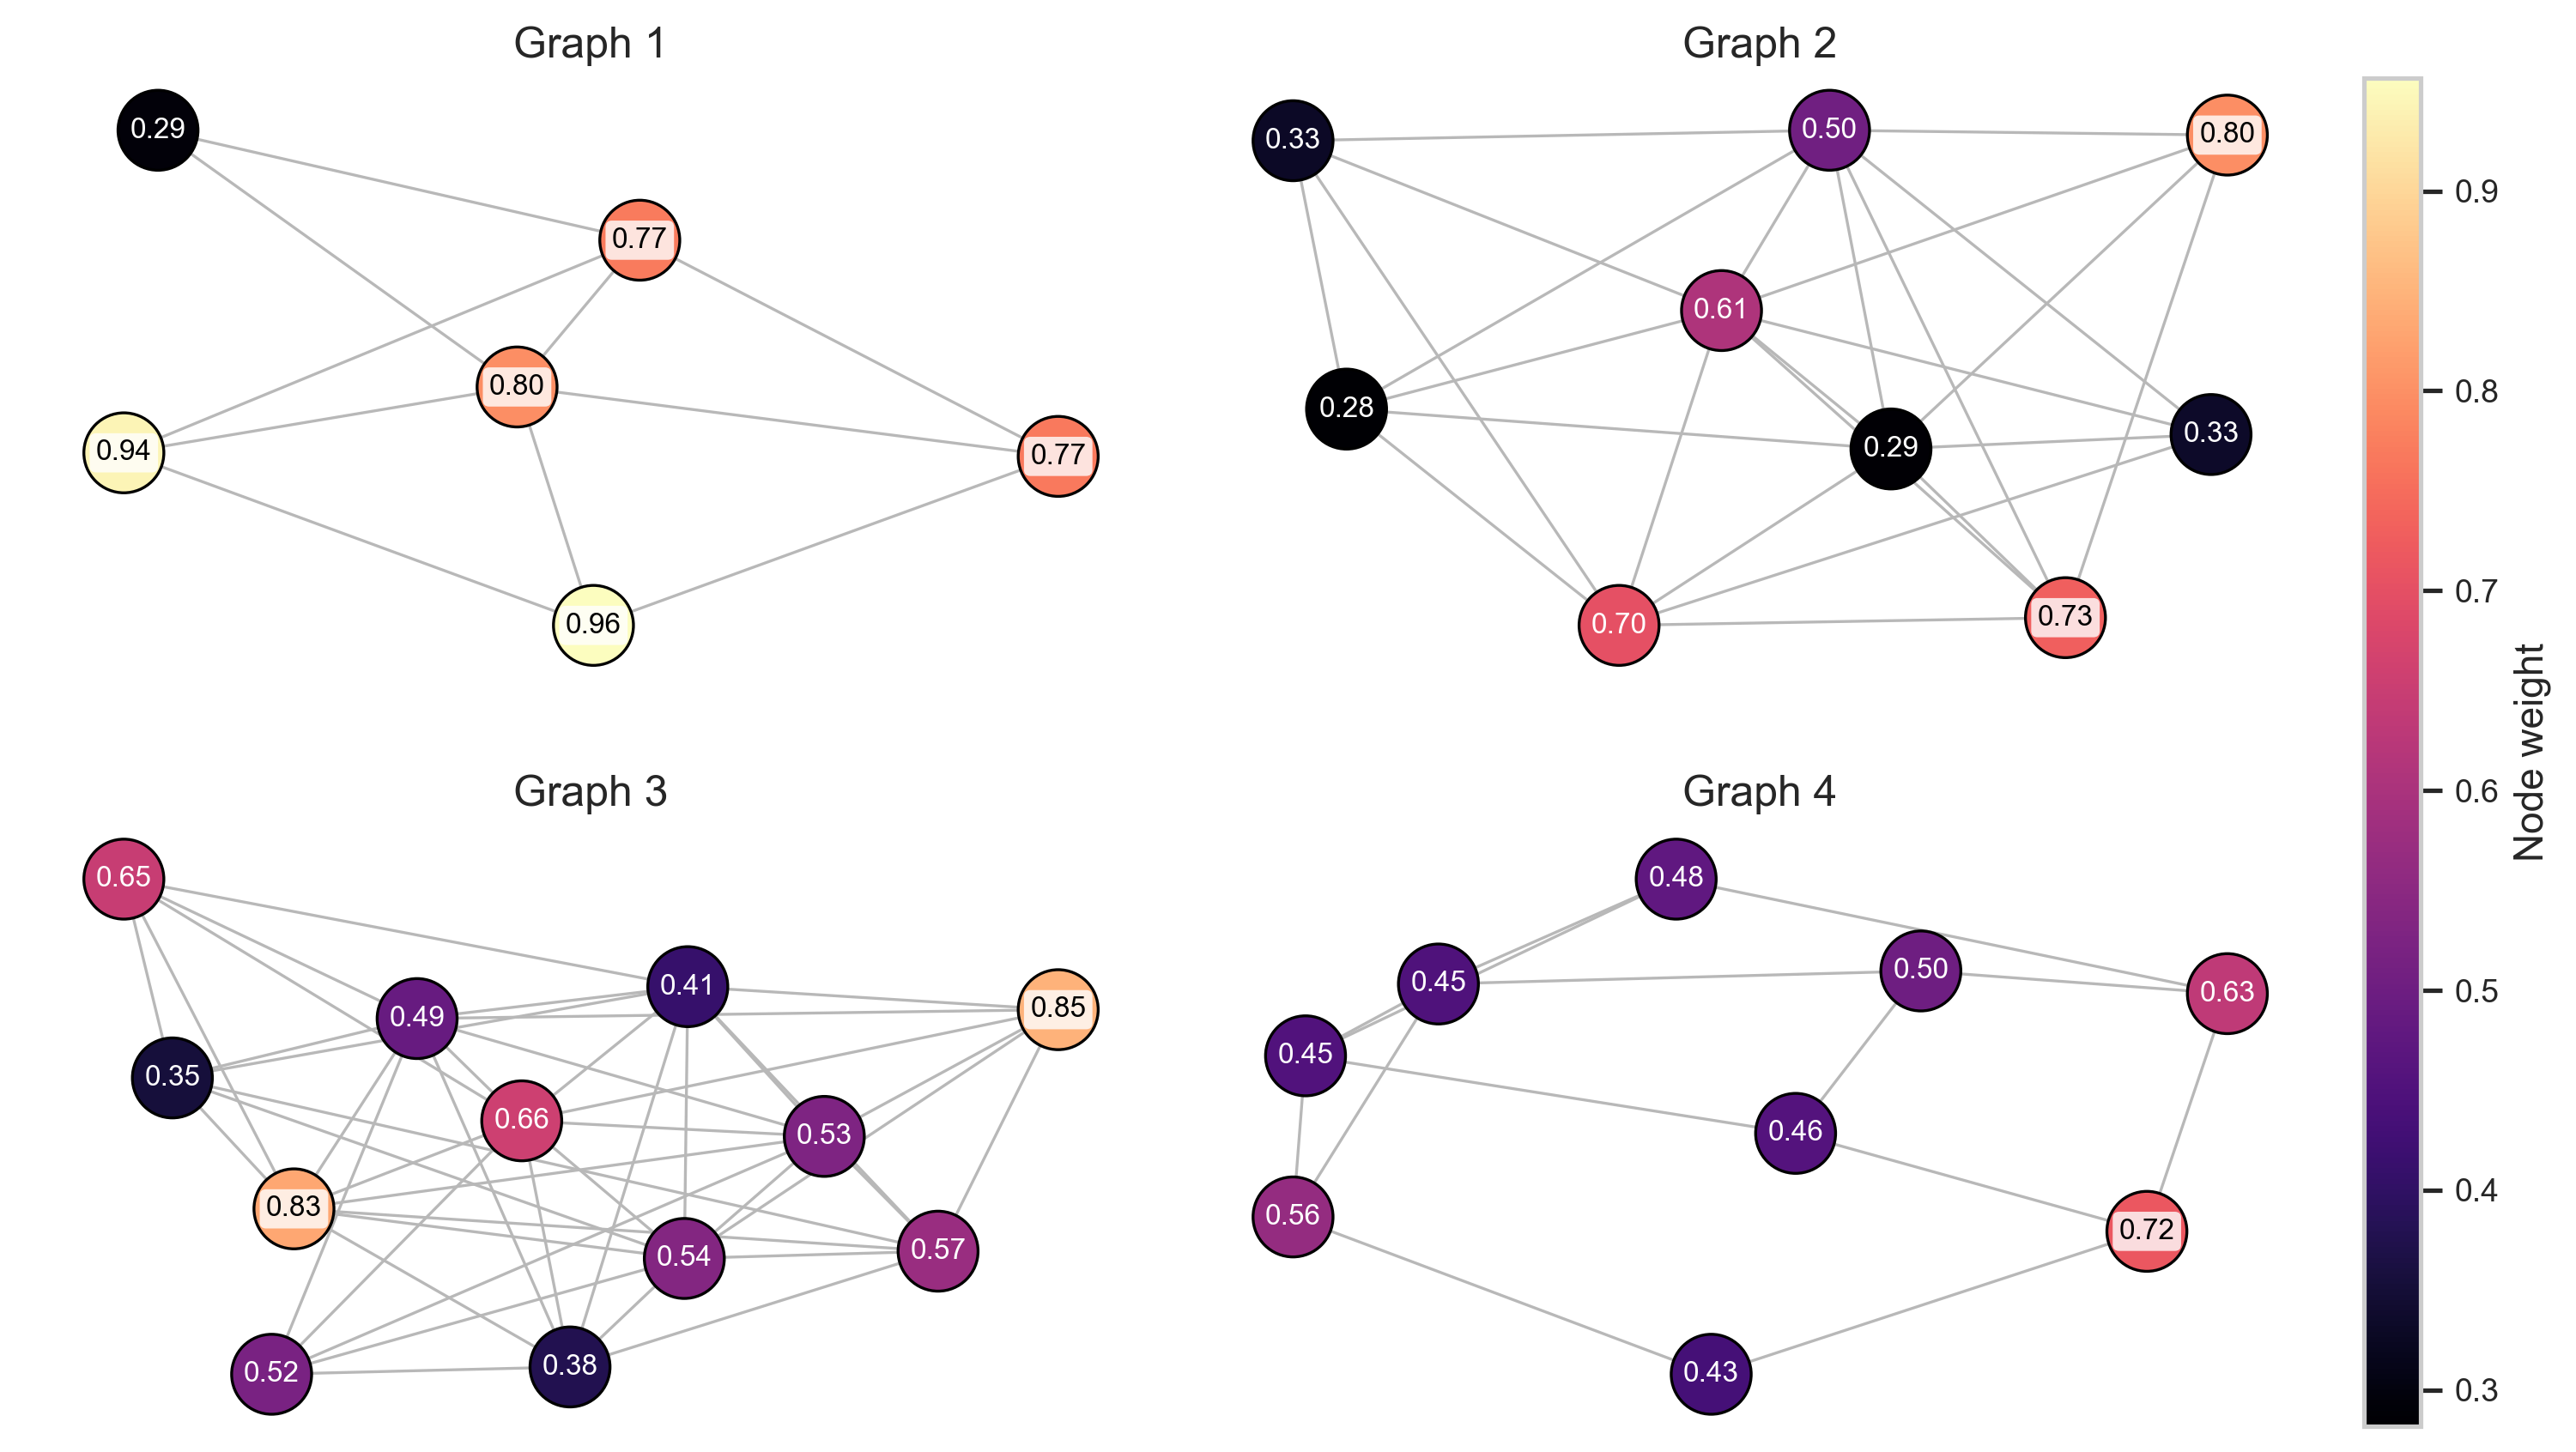

In [462]:
# ── graph_visualisation.py ──────────────────────────────────────────
"""
Generate a 2×2 panel of Erdős–Rényi graphs coloured by node weight.

▪ Requires:  matplotlib, networkx, rustworkx, numpy
▪ Run with :  python graph_visualisation.py
▪ Outputs  :  graphs_w_weights.pdf   (vector)
              graphs_w_weights.png   (hi-res raster)
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
import networkx as nx
import rustworkx as rx                    # only needed for the converter

# -------------------------------------------------------------------
# ❶  Bring / generate your problem graphs
# -------------------------------------------------------------------
from src.qaoa.models.MaxCutProblem import MaxCutProblem     # ← change to your actual import

problem = MaxCutProblem()
graphs_rx = problem.get_erdos_renyi_graphs_paper1()   # list[rx.PyGraph]

# -------------------------------------------------------------------
# ❷  Utility: Rustworkx → NetworkX
# -------------------------------------------------------------------
def rwx_to_nx(rwx_g: rx.PyGraph) -> nx.Graph:
    """Return a NetworkX clone of a rustworkx.PyGraph, preserving node weight."""
    H = nx.Graph()
    for n in rwx_g.node_indices():
        H.add_node(n, weight=rwx_g[n])
    H.add_edges_from(rwx_g.edge_list())
    return H

graphs_nx = [rwx_to_nx(g) for g in graphs_rx]

# -------------------------------------------------------------------
# ❸  Global colour normalisation
# -------------------------------------------------------------------
all_weights = [d["weight"] for G in graphs_nx for _, d in G.nodes(data=True)]
norm = colors.Normalize(vmin=min(all_weights), vmax=max(all_weights))
cmap = plt.cm.magma

# -------------------------------------------------------------------
# ❹  Build the figure: 2 × 2 panels + 1 column for colour-bar
# -------------------------------------------------------------------
fig = plt.figure(figsize=(12, 6.8), dpi=300)
gs  = gridspec.GridSpec(nrows=2, ncols=3,
                        width_ratios=[1, 1, 0.05],
                        wspace=0.05, hspace=0.25)

axes = [fig.add_subplot(gs[i//2, i % 2]) for i in range(4)]   # graph panels
cax  = fig.add_subplot(gs[:, 2])                              # colour-bar axis

# -------------------------------------------------------------------
# ❺  Draw each graph
# -------------------------------------------------------------------
for idx, (G, ax) in enumerate(zip(graphs_nx, axes)):
    weights = np.array([d["weight"] for _, d in G.nodes(data=True)])
    node_colors = cmap(norm(weights))
    pos = nx.spring_layout(G, seed=42)                        # deterministic

    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="0.72", width=0.8)

    # nodes
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_color=node_colors,
                           node_size=500,
                           linewidths=0.8,
                           edgecolors="black")

    # decide text colour from luminance
    luminance = np.dot(node_colors[:, :3], [0.2126, 0.7152, 0.0722])
    dark, light = luminance < 0.45, luminance >= 0.45
    nodes_dark  = [n for n, d in zip(G.nodes, dark) if d]
    nodes_light = [n for n, d in zip(G.nodes, light) if d]
    labels = {n: f"{w:.2f}" for n, w in zip(G.nodes, weights)}

    nx.draw_networkx_labels(
        G, pos, labels={n: labels[n] for n in nodes_light}, ax=ax,
        font_size=8, font_color="black",
        bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.8))

    nx.draw_networkx_labels(
        G, pos, labels={n: labels[n] for n in nodes_dark}, ax=ax,
        font_size=8, font_color="white",
        bbox=dict(boxstyle="round,pad=0.22", fc="black", ec="none", alpha=0.0))

    ax.set_title(f"Graph {idx+1}", fontsize=12)
    ax.set_axis_off()

# -------------------------------------------------------------------
# ❻  Shared vertical colour-bar
# -------------------------------------------------------------------
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label("Node weight", fontsize=11)
cbar.ax.tick_params(labelsize=9)

# -------------------------------------------------------------------
# ❼  Finish up
# -------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig("graphs_w_weights.pdf",  bbox_inches="tight")
fig.savefig("graphs_w_weights.png",  dpi=300, bbox_inches="tight")
plt.show()


In [463]:
#----------- interactive graph vizualiser--------------
from ipywidgets import interact, interactive_output, widgets, HBox, VBox
import matplotlib.pyplot as plt
import ast, pandas as pd

# --- basic controls ----------------------------------------------------------
graph_names = ['All'] + results['graph_name'].unique().tolist()
y_options   = ['ratio', 'time_elapsed', 'Iterations', 'percent_measure_optimal']
x_options   = ['qaoa_variant', 'depth', 'hamming_dist', 'warm_start',
               'lagrangian_multiplier','backend_mode']
hue_options = x_options.copy()
chart_types = ['bar', 'line', 'box']
ws_options  = [False, True]

graph_dd   = widgets.Dropdown(options=graph_names,  description='Graph:')
x_dd       = widgets.Dropdown(options=x_options,     description='X axis:')
y_dd       = widgets.Dropdown(options=y_options,     description='Y axis:')
hues_ms    = widgets.SelectMultiple(options=hue_options, description='Hues:')
chart_dd   = widgets.Dropdown(options=chart_types,   description='Chart:')
ws_dd      = widgets.Dropdown(options=ws_options,    description='Exclude WS?')

# --- helper to build one "filter row" ----------------------------------------
all_cols   = results.columns.tolist()
ops        = ['>', '>=', '<', '<=', '==', '!=']

def make_filter_row(i: int):
    """Return widgets for a single filter row."""
    enable   = widgets.Checkbox(value=False, description=f'Filter {i}')
    col      = widgets.Dropdown(options=all_cols, description='Column')
    op       = widgets.Dropdown(options=ops,      description='Op')
    val      = widgets.Text(description='Value')
    return enable, col, op, val

flt1_enable, flt1_col, flt1_op, flt1_val = make_filter_row(1)
flt2_enable, flt2_col, flt2_op, flt2_val = make_filter_row(2)

filter_box = VBox([
    HBox([flt1_enable, flt1_col, flt1_op, flt1_val]),
    HBox([flt2_enable, flt2_col, flt2_op, flt2_val])
])

# --- function that actually draws -------------------------------------------
def _apply_single_filter(df, enable, col, op, val):
    """Apply one filter if `enable` is True."""
    if not enable or col not in df.columns:
        return df  # skip invalid filters

    try:
        # Try evaluating the value as a Python literal
        val = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        try:
            # Fallback: coerce to column's dtype
            val = df[col].dtype.type(val)
        except Exception:
            pass  # Leave it as-is if all else fails

    expr = f"`{col}` {op} @val"
    return df.query(expr)


def update_visualization(graph_name, x, y, hues, chart,
                         exclude_warmstart,
                         # filter-1 widgets
                         f1_en, f1_col, f1_op, f1_val,
                         # filter-2 widgets
                         f2_en, f2_col, f2_op, f2_val):
    
    # --- start with the selected graph(s) ------------------------------------
    if graph_name == 'All':

        df = results.copy() 
    else:
        df = results[results['graph_name'] == graph_name].copy()
    
    # --- built-in warm-start exclusion ---------------------------------------
    if exclude_warmstart:
        df = df[df['hamming_dist'] == 0]
    
    # --- apply the two optional filters --------------------------------------
    df = _apply_single_filter(df, f1_en, f1_col, f1_op, f1_val)
    df = _apply_single_filter(df, f2_en, f2_col, f2_op, f2_val)
    
    # --- tidy + call your plotting helper ------------------------------------
    if hues:
        df = df.sort_values(by=[x] + list(hues))
    visualize(df, x=x, y=y, hues=list(hues), chart=chart)

# --- wire everything up ------------------------------------------------------
ui = VBox([
    HBox([graph_dd, x_dd, y_dd]),
    HBox([hues_ms, chart_dd, ws_dd]),
    filter_box
])

out = interactive_output(
    update_visualization,
    {
        'graph_name': graph_dd, 'x': x_dd, 'y': y_dd, 'hues': hues_ms,
        'chart': chart_dd, 'exclude_warmstart': ws_dd,
        
        # pipe the widgets for the two filters
        'f1_en': flt1_enable, 'f1_col': flt1_col, 'f1_op': flt1_op, 'f1_val': flt1_val,
        'f2_en': flt2_enable, 'f2_col': flt2_col, 'f2_op': flt2_op, 'f2_val': flt2_val
    }
)
display(ui, out)


Output()

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1297527895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_vanilla['param_str'] = (
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1297527895.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfect_vanilla['final_params'] = perfect_vanilla['final_params'].apply(convert_to_list)
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1297527895.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Number of perfect vanilla solutions: 507


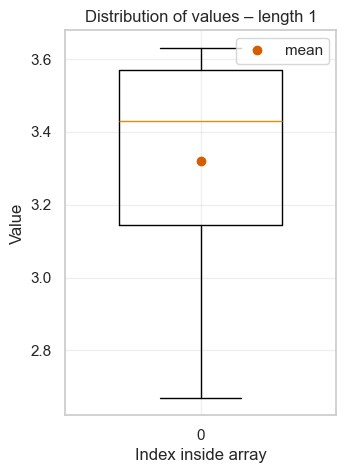

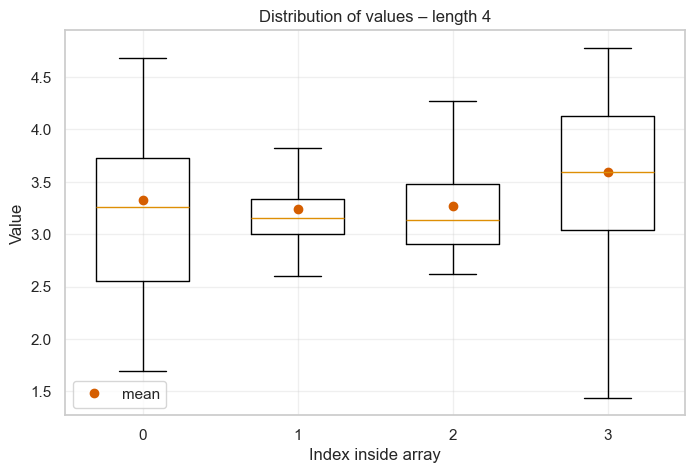

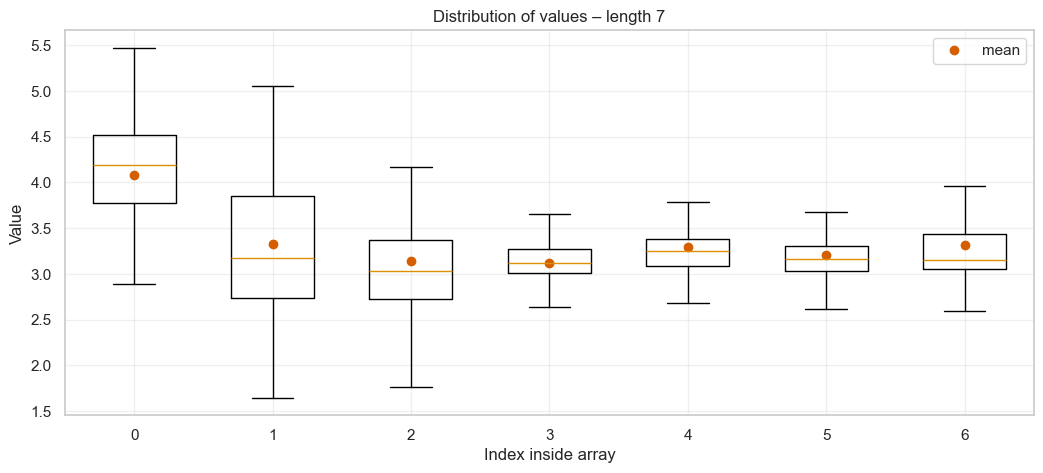

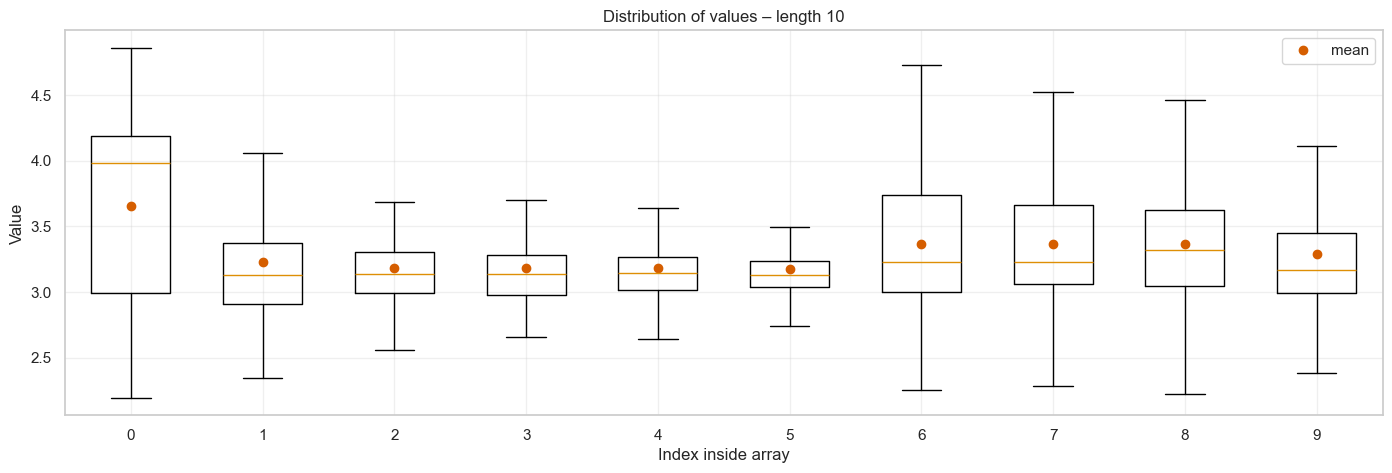

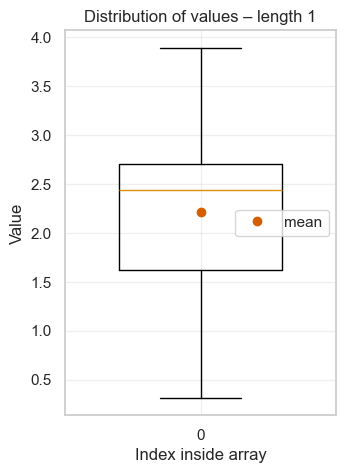

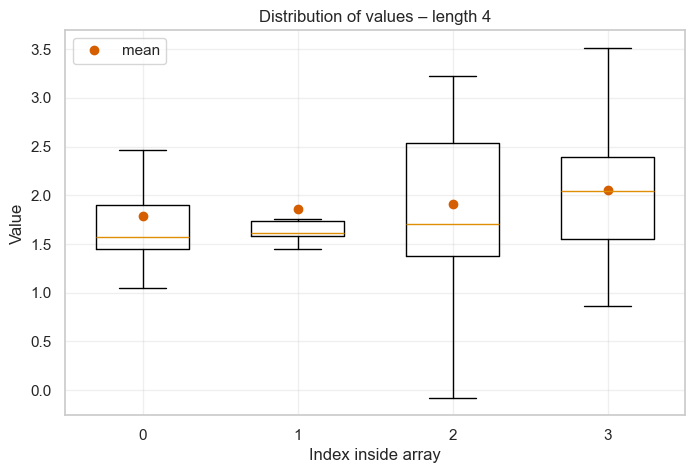

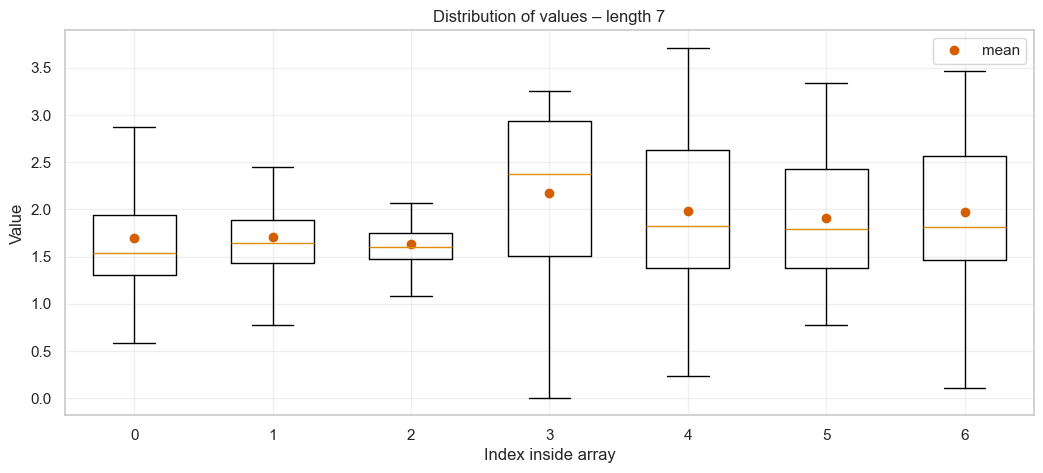

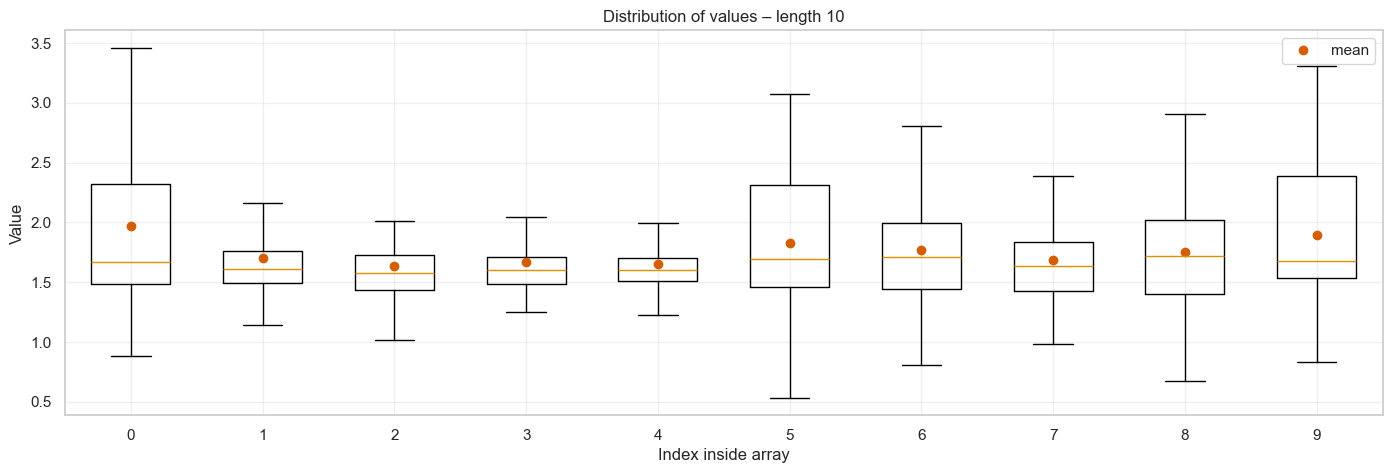

In [464]:
# Find and analyze all vanilla QAOA runs that achieved perfect solutions (ratio = 1)
perfect_vanilla = results[(results['qaoa_variant'] == 'vanilla') & (results['ratio'] == 1.0) & (results['backend_mode'] == 'statevector')]

# Display basic statistics
print(f"Number of perfect vanilla solutions: {len(perfect_vanilla)}")

perfect_vanilla['param_str'] = (
    perfect_vanilla['final_params']
      .str.replace(r'(?<=\d)\s+(?=\d)', ',', regex=True)
)

# Display the modified 'final_params' column

import ast
import pandas as pd
import re

# Function to clean and convert string to list
def convert_to_list(x):
    try:
        if isinstance(x, str) and x != '':
            # Replace multiple spaces with a single comma
            # This regex ensures we only replace spaces between numbers, not within brackets or elsewhere
            cleaned = re.sub(r'\s+', ',', x.strip())
            # Ensure the string is properly formatted (e.g., no trailing commas)
            cleaned = cleaned.strip('[],').strip()
            # Add back the list brackets if needed
            if not cleaned.startswith('['):
                cleaned = f'[{cleaned}]'
            return ast.literal_eval(cleaned)
        return x  # Return unchanged if not a string
    except (ValueError, SyntaxError):
        print(f"Failed to parse: {x}")
        return None  # or [] if you prefer an empty list

# Apply the conversion to the 'final_params' column
perfect_vanilla['final_params'] = perfect_vanilla['final_params'].apply(convert_to_list)
# Extract gammas (even indices) and betas (odd indices)
perfect_vanilla['gammas'] = perfect_vanilla['final_params'].apply(
    lambda x: x[::2]
)

perfect_vanilla['betas'] = perfect_vanilla['final_params'].apply(
    lambda x: x[1::2]
)
# Convert param_str to an array of floats
# Ensure that 'param_str' contains valid Python literals

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_by_length(df, col='gammas', lengths=(1, 4, 7, 10)):
    """
    For each desired length, draw a separate figure:
      • x-axis → position inside the array (0, 1, … L-1)
      • y-axis → value stored at that position
      • box-and-whisker shows the distribution,
        red dot marks the mean at each index.
    """
    # guard: keep only rows where the element is a list/array
    series = df[col].dropna()

    for L in lengths:
        # pick only arrays of length L
        arrs = series[series.apply(lambda x: len(x) == L)]
        if arrs.empty:
            print(f"No arrays of length {L} – skipping.")
            continue

        # build a list of lists: values_by_index[i] = all values at position i
        values_by_index = [[] for _ in range(L)]
        for a in arrs:
            for i, v in enumerate(a):
                values_by_index[i].append(v)

        # draw the figure
        fig, ax = plt.subplots(figsize=(1.5 * L + 2, 5))
        bp = ax.boxplot(
            values_by_index,
            positions=np.arange(L),
            widths=0.6,
            showfliers=False,
        )
        # overlay the means
        means = [np.mean(v) for v in values_by_index]
        ax.plot(np.arange(L), means, 'ro', label='mean')

        ax.set_title(f'Distribution of values – length {L}')
        ax.set_xlabel('Index inside array')
        ax.set_ylabel('Value')
        ax.set_xticks(np.arange(L))
        ax.legend()
        ax.grid(alpha=0.3)

        plt.show()

# usage:
plot_by_length(perfect_vanilla, col='gammas', lengths=(1, 4, 7, 10))
plot_by_length(perfect_vanilla, col='betas', lengths=(1, 4, 7, 10))


Group statistics for ratio by QAOA variant:
              count      mean       std  min       25%       50%      75%  \
qaoa_variant                                                                
multiangle    200.0  1.478060  0.352439  1.0  1.251143  1.415221  1.64532   
vanilla       200.0  2.165802  1.148396  1.0  1.481316  1.932175  2.51432   

                   max  
qaoa_variant            
multiangle    3.491244  
vanilla       7.727381  
             count unique    top freq
qaoa_variant                         
multiangle      50      1  False   50
vanilla         50      2   True   27
              count     mean        std    min    25%    50%    75%    max
qaoa_variant                                                              
multiangle    200.0  134.000   0.000000  134.0  134.0  134.0  134.0  134.0
vanilla       200.0   98.665  26.929515   61.0   73.0   91.5  134.0  134.0

Mean ratio for vanilla QAOA with depth=4: 2.1658
Mean ratio for multiangle QAOA: 1.4781
Averag

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\3856770002.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()])


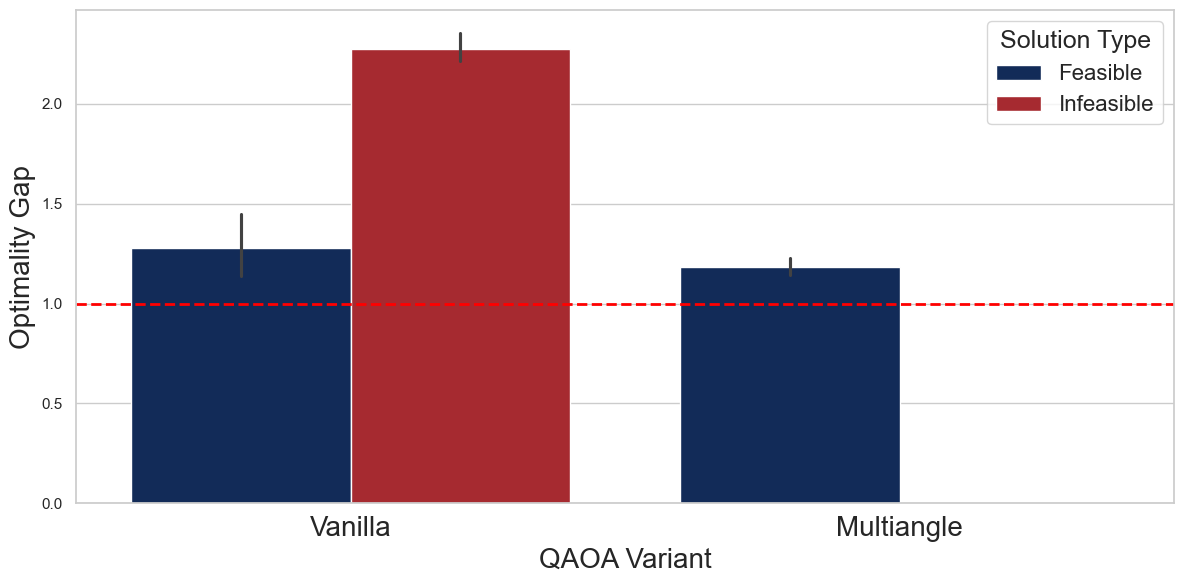

In [486]:
# Iteration - capped vanilla vs ma
filtered_data = results[
    (results['qaoa_variant'] == 'vanilla') & 
    (results['depth'] == 1) & 
    (results['warm_start'] == False) & 
    (results['backend_mode'] == 'statevector')
]


# Calculate the average of Iterations
avg_Iterations = filtered_data['Iterations'].mean()
df_limitruns = pd.read_csv("results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'vanilla','multiangle'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False},'problem_type'{'minvertexcover'}}.csv")
# Display group information about qaoa_variant and ratio

df_limitruns.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
g = problem.get_erdos_renyi_graphs_paper1()[0]

# create a networkx graph from the rustworkx graph
G = nx.Graph(list(g.edge_list()))
graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
solver = MinVertexCoverSolver(g, 'minvertexcover')
mask = df_limitruns['graph_name'] == graph6_string
df_limitruns.loc[df_limitruns['graph_name'] == graph6_string, 'infeasible']= df_limitruns.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
mask_ws = (df_limitruns['graph_name'] == graph6_string) & (df_limitruns['warm_start'] == True)
df_limitruns.loc[mask_ws, 'ws_value'] = df_limitruns.loc[mask_ws, 'hamming_string'].apply(
    lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
)


print("Group statistics for ratio by QAOA variant:")
print(df_limitruns.groupby('qaoa_variant')['ratio'].describe())
print(df_limitruns.groupby('qaoa_variant')['infeasible'].describe())
print(df_limitruns.groupby('qaoa_variant')['Iterations'].describe())
# Calculate the mean ratio for vanilla QAOA with depth=4
vanilla_depth4_ratio = df_limitruns[df_limitruns['qaoa_variant'] == 'vanilla']['ratio'].mean()
print(f"\nMean ratio for vanilla QAOA with depth=4: {vanilla_depth4_ratio:.4f}")

# Compare with multiangle if available
if 'multiangle' in df_limitruns['qaoa_variant'].unique():
    multiangle_ratio = df_limitruns[df_limitruns['qaoa_variant'] == 'multiangle']['ratio'].mean()
    print(f"Mean ratio for multiangle QAOA: {multiangle_ratio:.4f}")

print(f"Average quantum function evaluations for vanilla QAOA with depth=1, no warm start, and statevector backend: {avg_Iterations:.2f}")

# Create a proper figure with specific size
plt.figure(figsize=(12, 6))
# Create a bar plot showing ratio by QAOA variant, grouped by infeasibility
sns.barplot(data=df_limitruns, x='qaoa_variant', y='ratio', hue='infeasible', 
            palette={False: "#062864", True: "#BB151D"})

# Customize the plot
plt.ylabel('Optimality Gap', fontsize=20)
plt.xlabel('QAOA Variant', fontsize=20)
plt.xticks(fontsize=20)
ax = plt.gca()
ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()])

# Add a horizontal red line at ratio=1 to indicate optimal solution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Create custom legend with "Feasible" and "Infeasible" labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Feasible", "Infeasible"], title="Solution Type", fontsize=16, title_fontsize=18)

plt.savefig('capped_QFE.pdf', bbox_inches='tight')
# Remove any random lines and ensure clean output
plt.tight_layout()
plt.show()

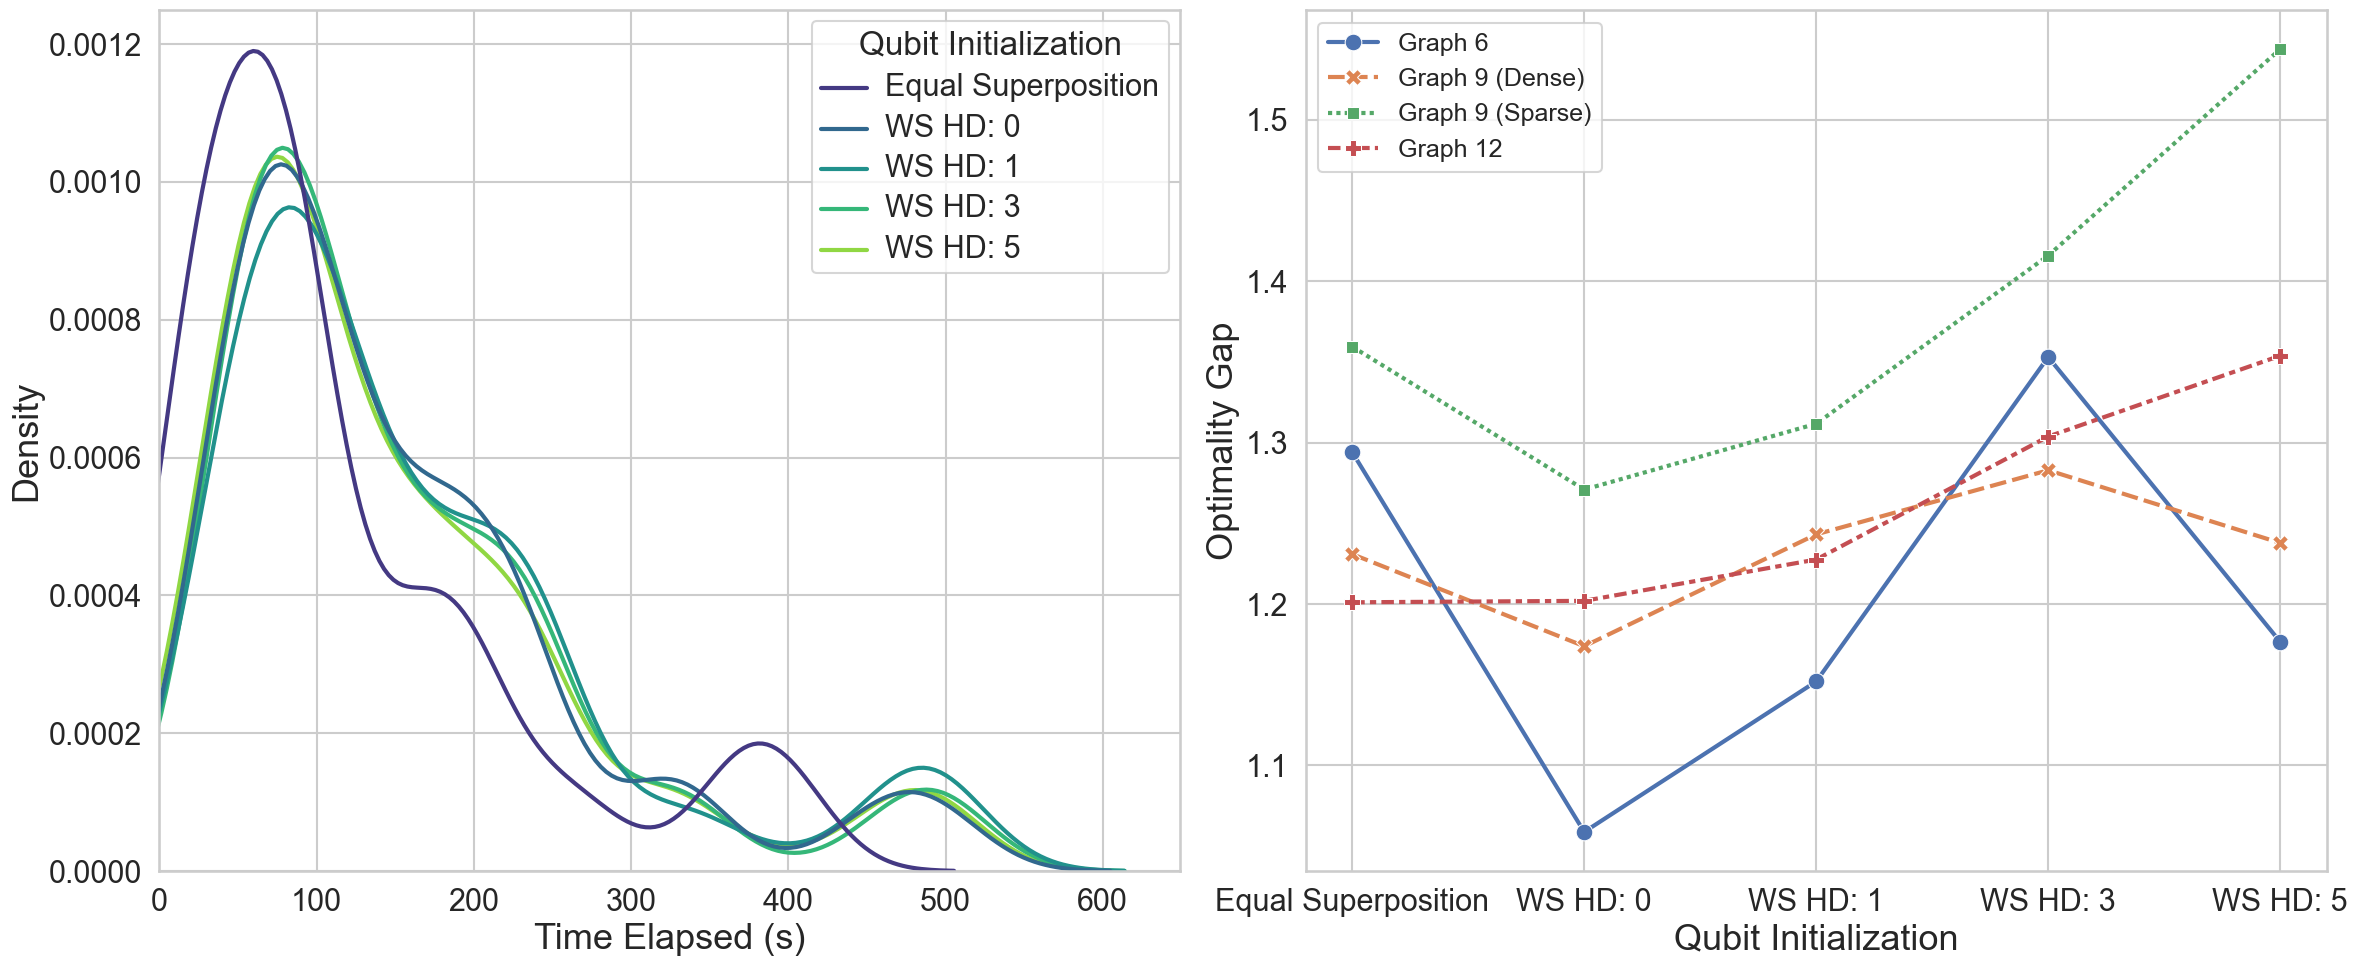

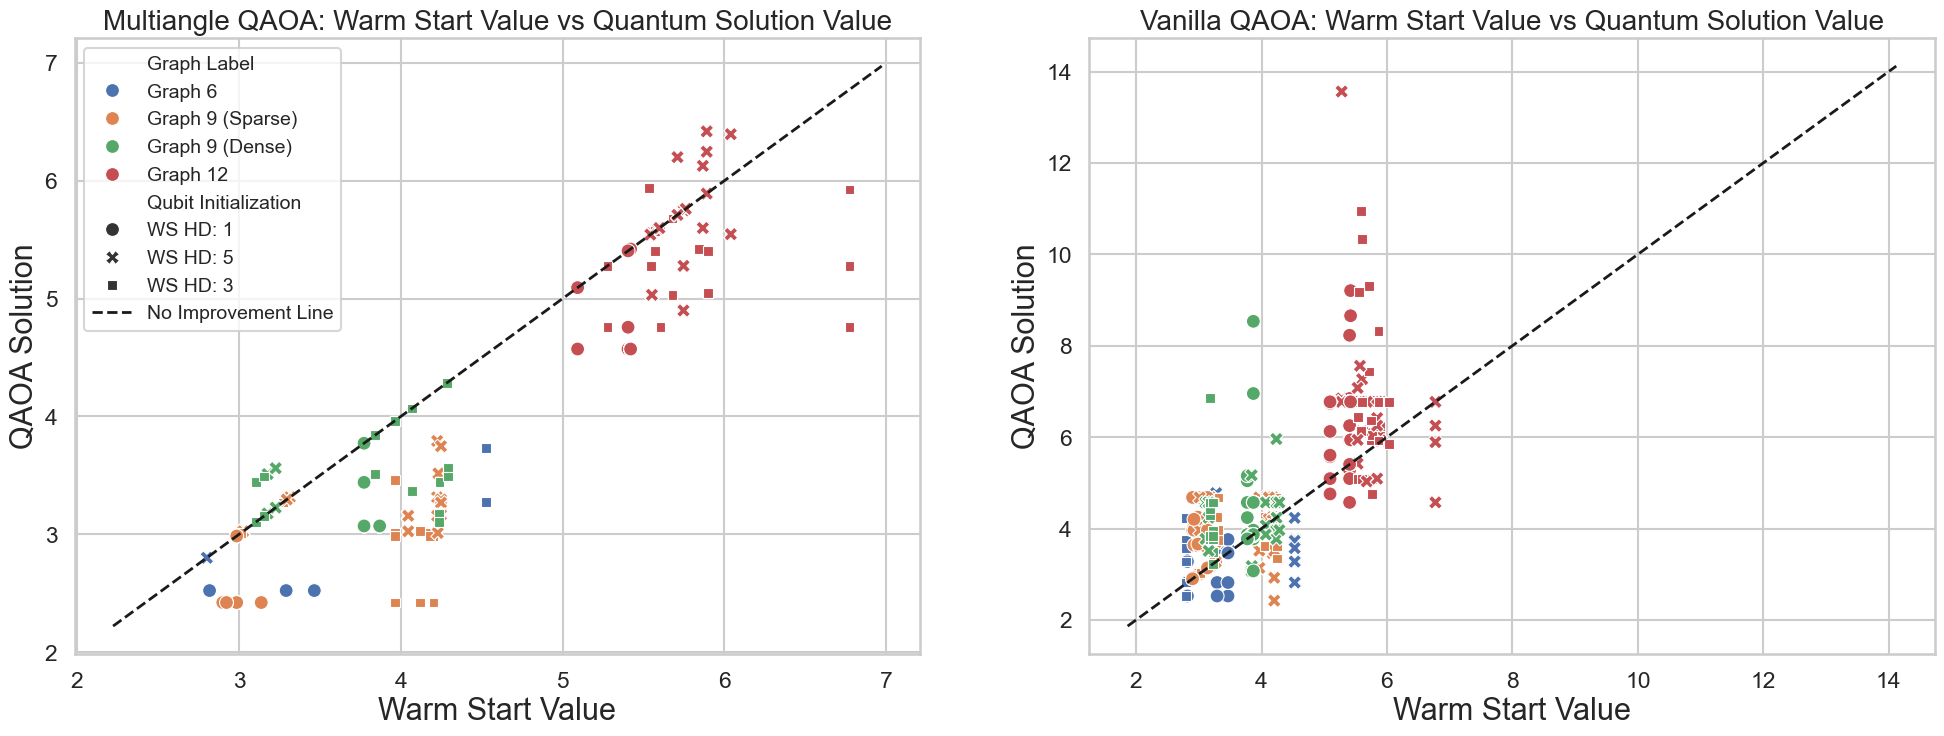

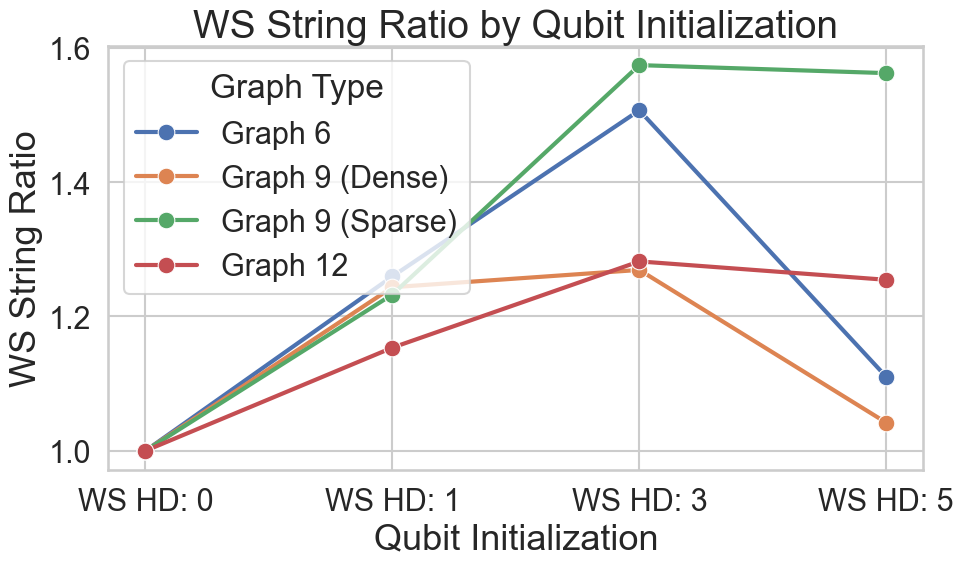

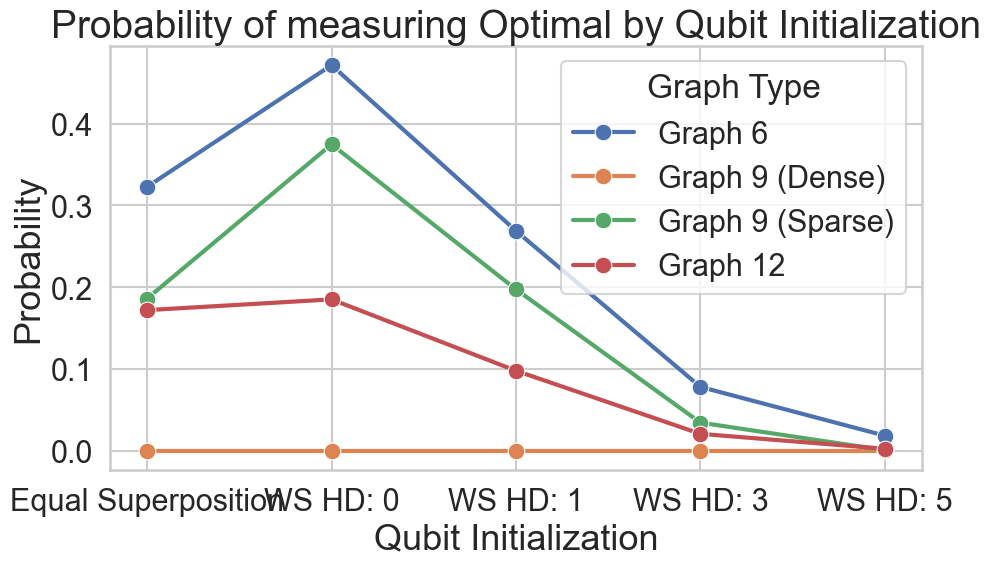

Lagrangian multipliers used: [2]


In [512]:
import numpy as np
import pandas as pd
import seaborn as sns

# Filter to only warm-started entries
df_ws = results[results['backend_mode']=='statevector'].copy()
#df_ws = df_ws[df_ws['warm_start'] == True]
df_ws['hamming_dist'] = df_ws['hamming_dist'].astype(int)


df_ws = df_ws[((df_ws['qaoa_variant'] == 'multiangle') & (df_ws['depth'] == 1)) |
              ((df_ws['qaoa_variant'] == 'vanilla') & (df_ws['depth'] == 4))]

# Cleaned labels
graph_label_map = {
    '>>graph6<<Emz_': 'Graph 6',
    '>>graph6<<HmzffJz': 'Graph 9 (Dense)',
    '>>graph6<<Hh_iS_u': 'Graph 9 (Sparse)',
    '>>graph6<<KmzffJznl{hU': 'Graph 12',
}
df_ws['graph_label'] = df_ws['graph_name'].map(graph_label_map)

label_map = {
    'False0': 'Equal Superposition',
    'True0': 'WS HD: 0',
    'True1': 'WS HD: 1',
    'True3': 'WS HD: 3',
    'True5': 'WS HD: 5',
}
df_ws['Qubit Initialization'] = df_ws['warm_start'].astype(str) + df_ws['hamming_dist'].astype(str)
df_ws['Qubit Initialization'] = df_ws['Qubit Initialization'].map(label_map)

# Group by hamming distance to compute percentage of infeasible runs
infeasible_pct = (
    df_ws.groupby('Qubit Initialization')['infeasible']
    .mean()
    .reset_index(name='perc_infeasible')
)
infeasible_pct['perc_infeasible'] *= 100

# Compute percent improvement from the warm-started string.
# 100 * (quantum_obj_value - ws_value) / quantum_obj_value.
df_ws = df_ws[df_ws['quantum_obj_value'] != 0].copy()
df_ws['ws_value'] = df_ws['ws_value'].astype(float)  # ensure numeric
df_ws['perc_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    100 * (df_ws['ws_value'] - df_ws['quantum_obj_value']) / df_ws['ws_value'],
    np.nan
)
df_ws['actual_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    df_ws['ws_value'] - df_ws['quantum_obj_value'],
    np.nan
)

# Create a 2x1 figure (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# 1) Runtime (time_elapsed) by hamming distance
sns.kdeplot(data=df_ws, x='time_elapsed', ax=axes[0], hue='Qubit Initialization', palette='viridis', linewidth=3,legend='full')
axes[0].set_ylabel('Density', fontsize=26)
axes[0].set_xlabel('Time Elapsed (s)', fontsize=26)
axes[0].set_xlim(left=0)
axes[0].tick_params(axis='both', labelsize=22)
leg = axes[0].get_legend()                     # legend Seaborn already created
leg.set_title("Qubit Initialization", prop={"size": 24})
for txt in leg.get_texts():
    txt.set_fontsize(22)
df_ws['ws_ratio'] = df_ws['ws_value']/df_ws['classic_value']

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")

# Create a separate lineplot for each qaoa_variant
        
# Create lineplot
sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='ratio',
    ax=axes[1],
    hue='graph_label',
    markersize=12,
    linewidth=3,
    errorbar=None,
    markers=True,
    style='graph_label'
)

axes[1].set_ylabel('Optimality Gap', fontsize=26)
axes[1].set_xlabel('Qubit Initialization', fontsize=26)
axes[1].tick_params(axis='both', labelsize=22)
axes[1].legend(fontsize=18)

plt.tight_layout()
plt.savefig('ws_stats.pdf', bbox_inches='tight')
plt.show()

# Create one plot with two subplots side by side for multiangle and vanilla QAOA variants
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.set_style("whitegrid")

for ax, qaoa_type in zip(axarr, ['multiangle', 'vanilla']):
    # Filter data for the current QAOA variant and warm-started solutions with hamming distance > 0
    current_df = df_ws[df_ws['qaoa_variant'] == qaoa_type].copy()
    current_df.rename(columns={'graph_label': 'Graph Label'}, inplace=True)
    ws_true = current_df[(current_df['warm_start'] == True) & (current_df['hamming_dist'] > 0)].copy()
    ws_true = ws_true.sort_values('graph_name')
    
    # Create a scatterplot on the current axis
    sns.scatterplot(
        data=ws_true,
        x='ws_value',
        y='quantum_obj_value',
        hue='Graph Label',
        style='Qubit Initialization',
        s=100,
        ax=ax
    )
    #ax.set_xlim(1.7,7)
    # Draw a diagonal line (y = x) to show the line of no improvement
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', linewidth=2, label='No Improvement Line')
    
    ax.set_title(f'{qaoa_type.capitalize()} QAOA: Warm Start Value vs Quantum Solution Value', fontsize=20)
    ax.set_xlabel('Warm Start Value', fontsize=22)
    ax.set_ylabel('QAOA Solution', fontsize=22)
    ax.legend(title_fontsize=16, fontsize=14)
    
# Remove the legend from the second subplot
axarr[1].get_legend().remove()

plt.savefig('warm_start_scatter_side_by_side.pdf', bbox_inches='tight')
df_ws


# Re-plot average ratio with ws_value overlaid as dotted lines
plt.figure(figsize=(10, 6))

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")
ax = sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='ws_ratio',
    marker='o',
    markersize=12,
    linewidth=3,
    color='C0',
    errorbar=None,
    hue='graph_label'
)
ax.set_title('WS String Ratio by Qubit Initialization', fontsize=28)
ax.set_ylabel('WS String Ratio', fontsize=26)
ax.set_xlabel('Qubit Initialization', fontsize=26)
ax.tick_params(axis='both', labelsize=22)
ax.legend(title='Graph Type', title_fontsize=24, fontsize=22)
plt.tight_layout()
plt.savefig('ws_string_ratio.pdf', bbox_inches='tight')
plt.show()

# Re-plot average ratio with ws_value overlaid as dotted lines
plt.figure(figsize=(10, 6))

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")
ax = sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='percent_measure_optimal',
    marker='o',
    markersize=12,
    linewidth=3,
    color='C0',
    errorbar=None,
    hue='graph_label'
)
ax.set_title('Probability of measuring Optimal by Qubit Initialization', fontsize=28)
ax.set_ylabel('Probability', fontsize=26)
ax.set_xlabel('Qubit Initialization', fontsize=26)
ax.tick_params(axis='both', labelsize=22)
ax.legend(title='Graph Type', title_fontsize=24, fontsize=22)
plt.tight_layout()
plt.savefig('perc_measure_optimal_HD.pdf', bbox_inches='tight')
plt.show()

print("Lagrangian multipliers used:", df_ws['lagrangian_multiplier'].unique())

  qaoa_variant Qubit Initialization  Improved %  Same %  Worsened % Count
0   multiangle             WS HD: 0         0.0   100.0         0.0   200
1   multiangle             WS HD: 1        78.5    21.5         0.0   200
2   multiangle             WS HD: 3        57.5    37.0         5.5   200
3   multiangle             WS HD: 5        19.0    66.0        15.0   200
4      vanilla             WS HD: 0         0.0    25.0        75.0   200
5      vanilla             WS HD: 1        10.0    25.0        65.0   200
6      vanilla             WS HD: 3        21.5    22.5        56.0   200
7      vanilla             WS HD: 5         9.0    16.0        75.0   200


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\816634162.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  improvement_stats = pd.concat([improvement_stats, new_row], ignore_index=True)
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\816634162.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\816634162.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')


<Figure size 1600x800 with 0 Axes>

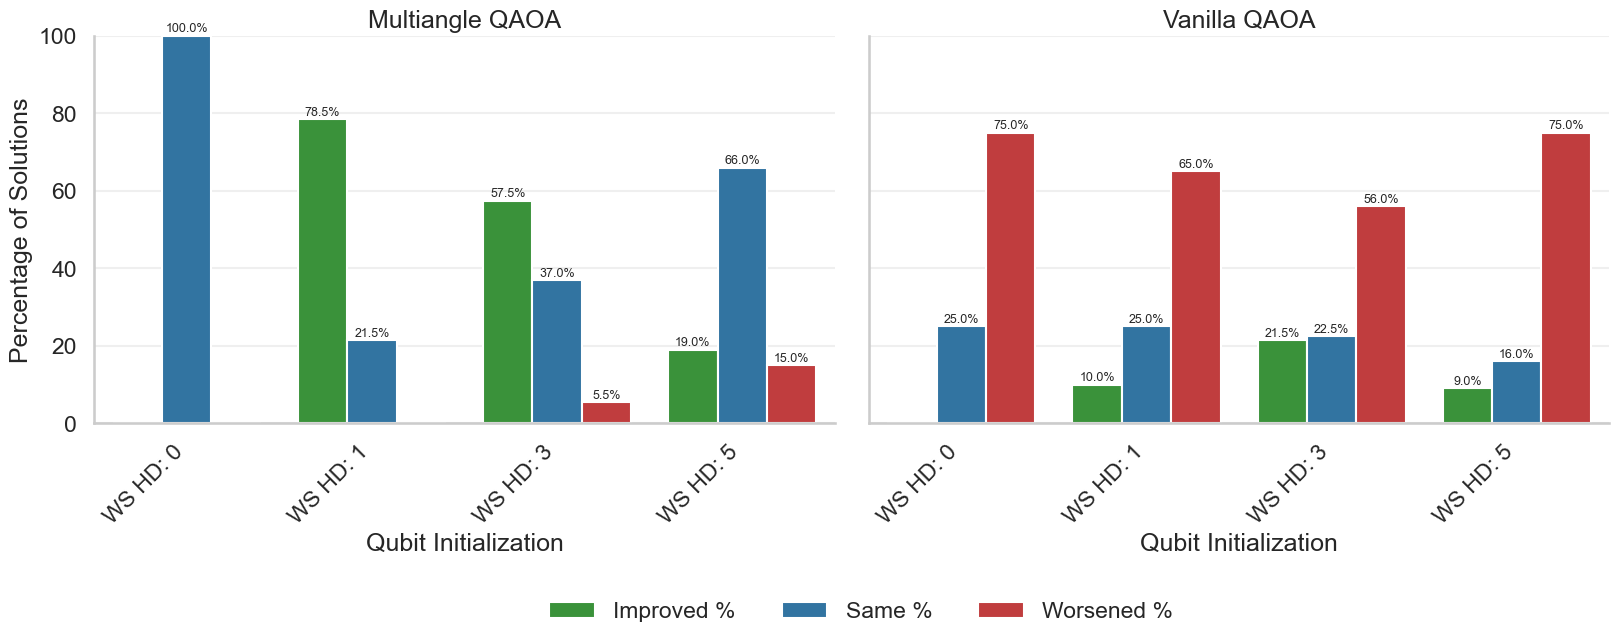

,qaoa_variant,Qubit Initialization,Improved %,Same %,Worsened %,Count
0,multiangle,WS HD: 0,0.0,100.0,0.0,200
1,multiangle,WS HD: 1,78.5,21.5,0.0,200
2,multiangle,WS HD: 3,57.5,37.0,5.5,200
3,multiangle,WS HD: 5,19.0,66.0,15.0,200
4,vanilla,WS HD: 0,0.0,25.0,75.0,200
5,vanilla,WS HD: 1,10.0,25.0,65.0,200
6,vanilla,WS HD: 3,21.5,22.5,56.0,200
7,vanilla,WS HD: 5,9.0,16.0,75.0,200


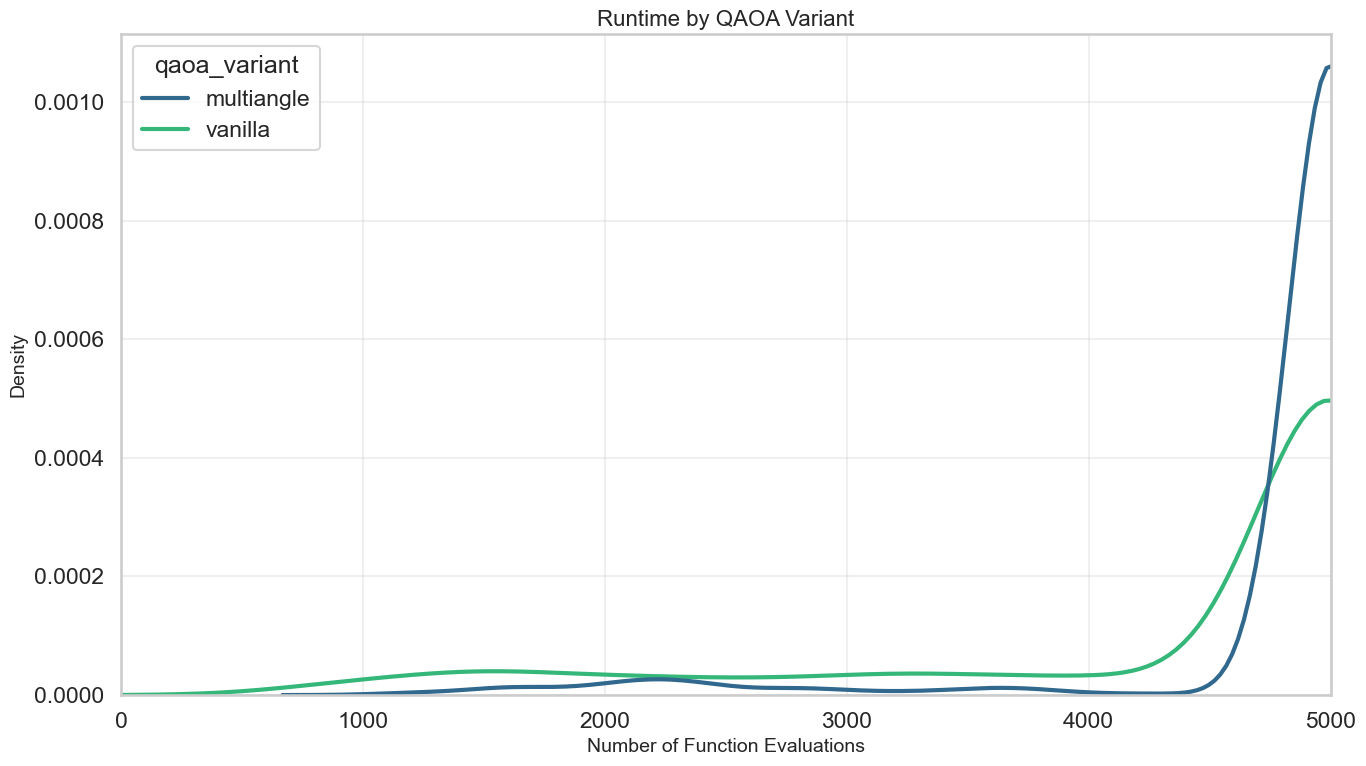

In [467]:
df_ws = results[results['backend_mode']=='statevector'].copy()
df_ws['hamming_dist'] = df_ws['hamming_dist'].astype(int)

df_ws['actual_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    df_ws['ws_value'] - df_ws['quantum_obj_value'],
    np.nan
)
df_ws = df_ws[((df_ws['qaoa_variant'] == 'multiangle') & (df_ws['depth'] == 1)) |
              ((df_ws['qaoa_variant'] == 'vanilla') & (df_ws['depth'] == 4))]

# Cleaned labels
graph_label_map = {
    '>>graph6<<Emz_': 'Graph 6',
    '>>graph6<<HmzffJz': 'Graph 9 (Dense)',
    '>>graph6<<Hh_iS_u': 'Graph 9 (Sparse)',
    '>>graph6<<KmzffJznl{hU': 'Graph 12',
}
df_ws['graph_label'] = df_ws['graph_name'].map(graph_label_map)

label_map = {
    'False0': 'Equal Superposition',
    'True0': 'WS HD: 0',
    'True1': 'WS HD: 1',
    'True3': 'WS HD: 3',
    'True5': 'WS HD: 5',
}
df_ws['Qubit Initialization'] = df_ws['warm_start'].astype(str) + df_ws['hamming_dist'].astype(str)
df_ws['Qubit Initialization'] = df_ws['Qubit Initialization'].map(label_map)
# Create a new dataframe to analyze improvement statistics
improvement_stats = pd.DataFrame(columns=['qaoa_variant', 'Qubit Initialization', 'Improved %', 'Same %', 'Worsened %', 'Count'])

# Include all warm started data including hamming distance 0
ws_all = df_ws.copy()

# Filter out Equal Superposition for the visualization
ws_all_filtered = ws_all[ws_all['Qubit Initialization'] != 'Equal Superposition']
ws_all_filtered['Qubit Initialization'].unique()
# Create a figure for both variants together
plt.figure(figsize=(16, 8))

# For each initialization type and QAOA variant, compute improvement statistics
for qaoa_var in ['multiangle', 'vanilla']:
    ws_filtered = ws_all_filtered[ws_all_filtered['qaoa_variant'] == qaoa_var]

    for init_type in ws_filtered['Qubit Initialization'].unique():
        subset = ws_filtered[ws_filtered['Qubit Initialization'] == init_type]
        total = len(subset)
        if total > 0:  # Only process if we have data for this combination
            # Calculate percentages
            improved = (subset['actual_improvement'] > 0.0001).sum() / total * 100
            same = (abs(subset['actual_improvement']) <= 0.0001).sum() / total * 100 
            worsened = (subset['actual_improvement'] < -0.0001).sum() / total * 100
            
            # Add to results dataframe
            new_row = pd.DataFrame({
                'qaoa_variant': [qaoa_var],
                'Qubit Initialization': [init_type],
                'Improved %': [improved],
                'Same %': [same], 
                'Worsened %': [worsened],
                'Count': [total]
            })
            improvement_stats = pd.concat([improvement_stats, new_row], ignore_index=True)
print(improvement_stats)
# Sort by initialization type and variant
improvement_stats = improvement_stats.sort_values(['qaoa_variant', 'Qubit Initialization'])
# Create a nice visualization with both variants side by side
# Filter out Equal Superposition for the visualization
improvement_stats_filtered = improvement_stats[improvement_stats['Qubit Initialization'] != 'Equal Superposition']
improvement_stats_melted = pd.melt(
    improvement_stats_filtered, 
    id_vars=['qaoa_variant', 'Qubit Initialization', 'Count'],
    value_vars=['Improved %', 'Same %', 'Worsened %'],
    var_name='Result', value_name='Percentage'
)
# Set up a custom color palette
palette = {'Improved %': '#2ca02c', 'Same %': '#1f77b4', 'Worsened %': '#d62728'}

# Create a grouped bar chart with both variants side by side
ax = sns.catplot(
    data=improvement_stats_melted, 
    x='Qubit Initialization', 
    y='Percentage', 
    hue='Result', 
    col='qaoa_variant',
    kind='bar',
    palette=palette,
    height=6, aspect=1.2
)
# Clean up extra legends

sns.move_legend(ax, 'lower left', bbox_to_anchor= (0.33,-0.1),ncol=3,title=None)
# Set titles and labels
ax.set_axis_labels(None, 'Percentage of Solutions')
ax.set_titles(col_template='{col_name} QAOA')

# Adjust ylim
for ax_i in ax.axes[0]:
    ax_i.set_ylim(0, 100)
    ax_i.grid(axis='y', alpha=0.3)
    # Add percentage values on top of each bar
    for p in ax_i.patches:
        height = p.get_height()
        if height > 0:
            ax_i.text(
                p.get_x() + p.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', 
                fontsize=9
            )
    
    # Clean up x-axis labels
    ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')

# Capitalize first letter of each subplot title
for ax_i, title in zip(ax.axes[0], ['Multiangle', 'Vanilla']):
    ax_i.set_title(f"{title} QAOA")

plt.tight_layout()
plt.savefig('warm_start_improvement_stats_combined.pdf', bbox_inches='tight')
plt.show()

# Display the detailed table
display(improvement_stats.round(2))


# Create a figure and analyze runtime performance
plt.figure(figsize=(14, 8))

# Plot runtime distribution by QAOA variant
sns.kdeplot(data=df_ws, x='Iterations', hue='qaoa_variant', palette='viridis', linewidth=3)

# Set plot styling
plt.title('Runtime by QAOA Variant', fontsize=16)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Number of Function Evaluations', fontsize=14)
plt.xlim((0,5000))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('runtime_by_qaoa_variant.pdf', bbox_inches='tight')
plt.show()

infeasible
False    737
True      63
Name: count, dtype: int64


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\791019116.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feasible_df.loc[mask, 'quantum_obj_value']= feasible_df.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=False))
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\791019116.py:35: UserWarning: The dashes list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


<Figure size 1200x600 with 0 Axes>

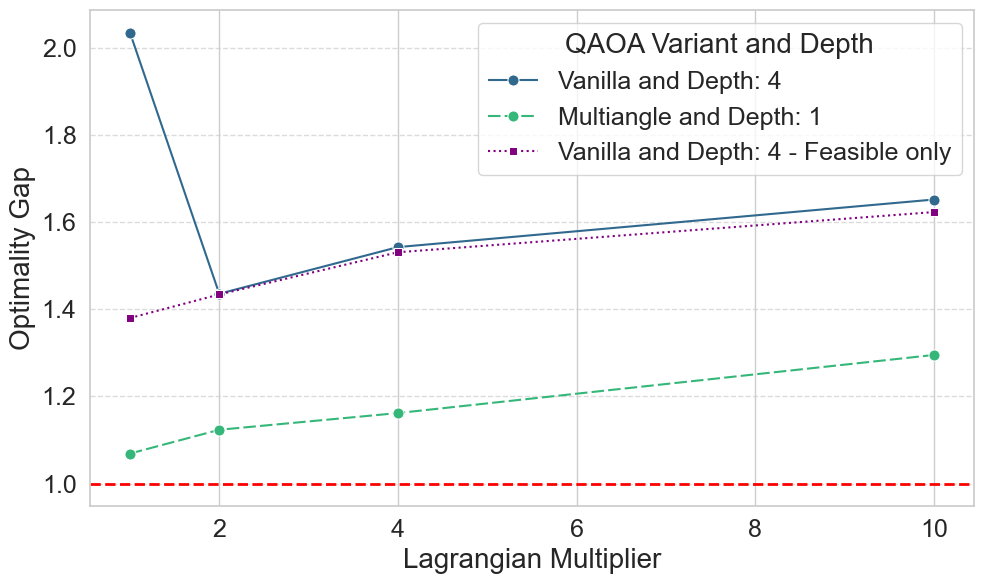

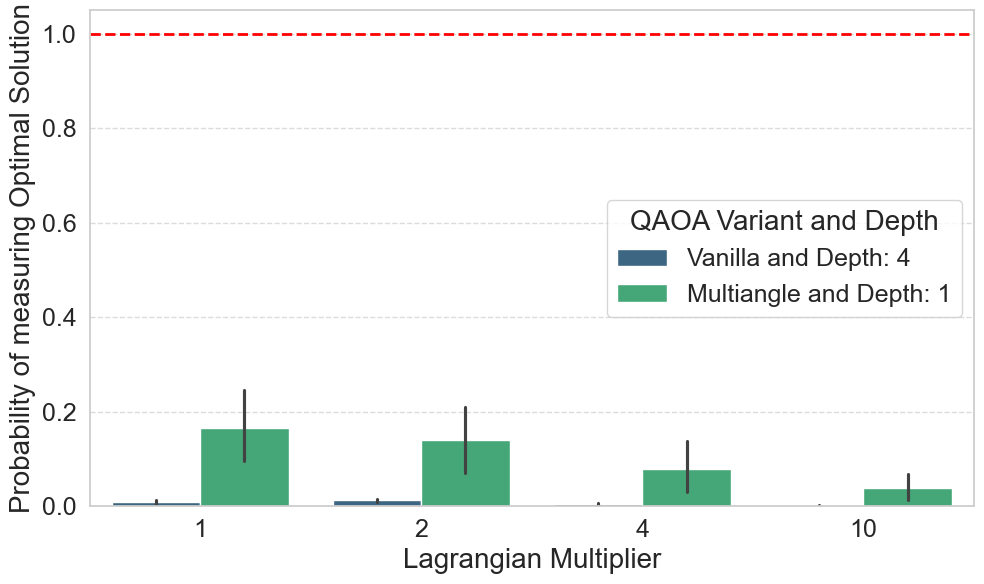

"\nplt.title('Runtime by Lagrangian Multiplier', fontsize=14)\n# Customize the plot\n\nsns.barplot(\n    palette='viridis',\n    hue='QAOA Implementation',\n    y='time_elapsed',\n    x='lagrangian_multiplier', \n    data=feasible_df, )\n\nplt.figure(figsize=(12, 6)) # Create a figure for quantum function evaluations by Lagrangian multiplier\nplt.figure(figsize=(12, 6))\n\nplt.title('Runtime by Lagrangian Multiplier', fontsize=14)# Customize the plotntation',tiplier',    data=subset, sns.barplot( Create a figure for runtime by Lagrangian multiplier# Create a figure for quantum function evaluations by Lagrangian multiplier\n\n# Create the boxplot to show distribution\nsns.barplot(\n    data=feasible_df, \n    x='lagrangian_multiplier', \n    y='Iterations',\n    hue='QAOA Implementation',\n    palette='viridis'\n)\n\n# Customize the plot\nplt.title('QAOA Iterations Lagrangian Multiplier', fontsize=14)\nplt.xlabel('Lagrangian Multiplier', fontsize=12)\nplt.ylabel('QAOA Iterations', fonts

In [496]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="colorblind")
# Create a visualization to analyze solution ratio by lagrangian multiplier and qaoa variant
plt.figure(figsize=(12, 6))


feasible_df = results_lagrange.copy()
# Filter only feasible solutions
#feasible_df = results_lagrange[results_lagrange['infeasible'] == False].copy()
feasible_df = feasible_df[feasible_df['warm_start']==False]
#feasible_df = results_lagrange.copy()
print(feasible_df['infeasible'].value_counts())

for g in graphs:
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover',lagrangian=2)
    mask = feasible_df['graph_name'] == graph6_string
    feasible_df.loc[mask, 'quantum_obj_value']= feasible_df.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=False))
feasible_df['ratio'] = feasible_df['quantum_obj_value'] / feasible_df['classic_value']

feasible_df['QAOA Implementation'] = feasible_df.apply(lambda row: f"{row['qaoa_variant'].capitalize()} and Depth: {row['depth']}", axis=1)
#feasible_df['QAOA Implementation'] = feasible_df.apply(lambda row: f"{row['QAOA Implementation']} with {row['infeasible']}", axis=1)


# Create the barplot
# Create a figure with 1 row and 2 columns for side-by-side plots
# Create a figure for the first plot (ratio vs lagrangian multiplier)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=feasible_df, 
    x='lagrangian_multiplier', 
    y='ratio',
    hue='QAOA Implementation',
    palette='viridis',
    errorbar=None,
    marker='o',
    markersize=8,
    style='QAOA Implementation',  # Use different line styles by QAOA variant
    dashes=[(1, 0), (6, 2), (3, 1), (4, 2)]  # Custom dash patterns
)

ONE_IMPL = 'Vanilla and Depth: 4'    # e.g. 'QAOA-C' or whatever is in the column
subset = feasible_df[
    (feasible_df['QAOA Implementation'] == ONE_IMPL) &
    (feasible_df['infeasible'] == False)
]

sns.lineplot(
    data=subset,
    x='lagrangian_multiplier',
    y='ratio',
    label=f'{ONE_IMPL} - Feasible only',
    linestyle=':',              
    marker='s',
    color='purple',
    errorbar=None
)

# Customize the plot
plt.xlabel('Lagrangian Multiplier', fontsize=20)
plt.ylabel('Optimality Gap', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='QAOA Variant and Depth', title_fontsize=20, fontsize=18, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=18)

# Add horizontal line at ratio=1 to indicate optimal solution quality
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig('lagrangian_ratio_plot.pdf', bbox_inches='tight')
plt.show()

# Create a figure for the second plot (percent_measure_optimal)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feasible_df, 
    x='lagrangian_multiplier', 
    y='percent_measure_optimal', 
    hue='QAOA Implementation', 
    palette='viridis'
)

# Add horizontal line at ratio=1 to indicate optimal solution quality
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Customize the plot
plt.xlabel('Lagrangian Multiplier', fontsize=20)
plt.ylabel('Probability of measuring Optimal Solution', fontsize=20)
plt.legend(title='QAOA Variant and Depth', fontsize=18, title_fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('lagrangian_probability_plot.pdf', bbox_inches='tight')
plt.show()

#

"""
plt.title('Runtime by Lagrangian Multiplier', fontsize=14)
# Customize the plot

sns.barplot(
    palette='viridis',
    hue='QAOA Implementation',
    y='time_elapsed',
    x='lagrangian_multiplier', 
    data=feasible_df, )

plt.figure(figsize=(12, 6)) # Create a figure for quantum function evaluations by Lagrangian multiplier
plt.figure(figsize=(12, 6))

plt.title('Runtime by Lagrangian Multiplier', fontsize=14)# Customize the plotntation',tiplier',    data=subset, sns.barplot( Create a figure for runtime by Lagrangian multiplier# Create a figure for quantum function evaluations by Lagrangian multiplier

# Create the boxplot to show distribution
sns.barplot(
    data=feasible_df, 
    x='lagrangian_multiplier', 
    y='Iterations',
    hue='QAOA Implementation',
    palette='viridis'
)

# Customize the plot
plt.title('QAOA Iterations Lagrangian Multiplier', fontsize=14)
plt.xlabel('Lagrangian Multiplier', fontsize=12)
plt.ylabel('QAOA Iterations', fontsize=12)
plt.legend(title='QAOA Variant and Depth', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('lagrangian_func_evals.pdf', bbox_inches='tight')
plt.show()

sns.kdeplot(data= feasible_df, x = 'Iterations' , hue='QAOA Implementation', multiple='stack',palette='viridis')
plt.xlim((0,5000))
sns.despine()

plt.xlabel('Iterations', fontsize= 12)
plt.savefig('lagrangian_kdeplot.pdf', bbox_inches='tight')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=feasible_df,
    x='lagrangian_multiplier',
    y='time_elapsed',
    palette='viridis'
)


"""
# Create a figure for runtime by Lagrangian multiplier

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\3237566734.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No WS' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.loc[variant_df['warm_start']==False, 'hamming_dist'] = 'No WS'
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\3237566734.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No WS' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.loc[variant_df['warm_start']==False, 'hamming_dist'] = 'No WS'


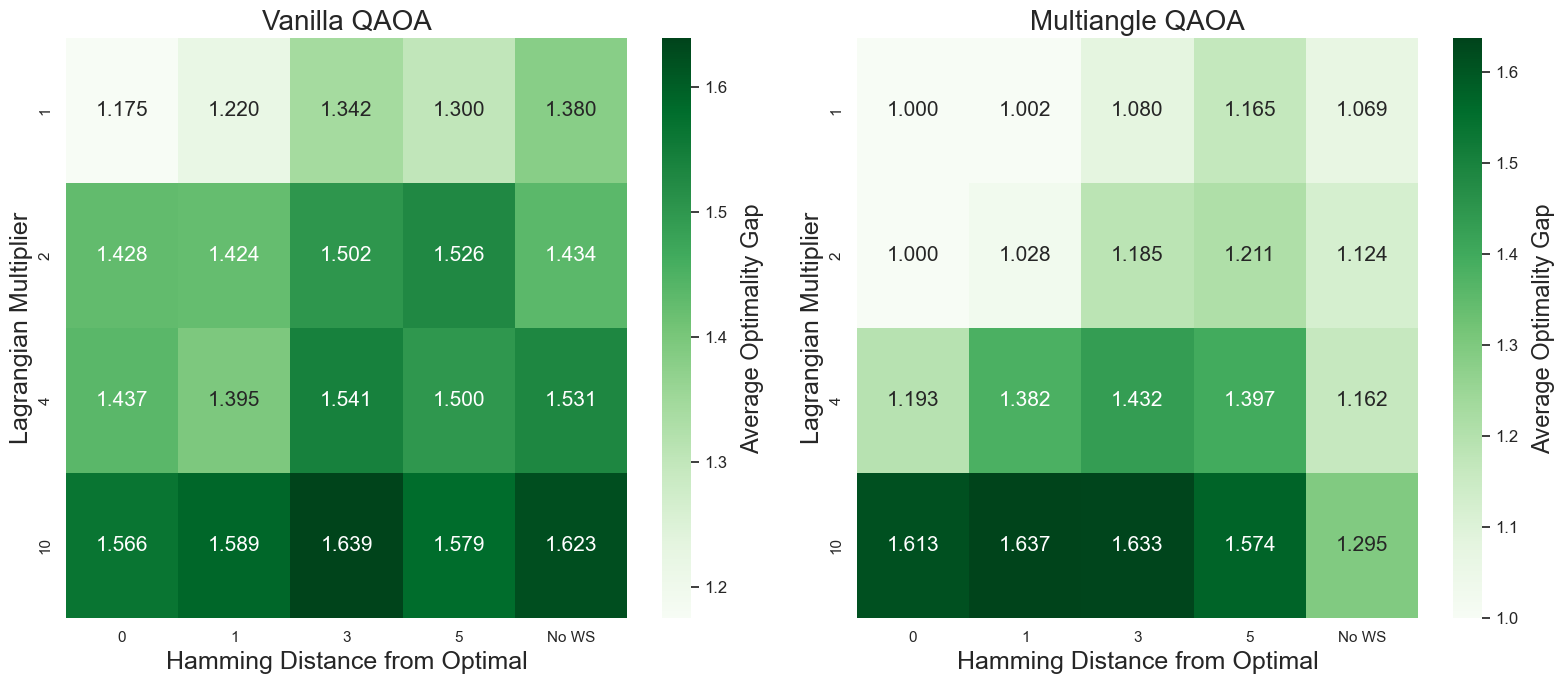

In [469]:
#---------heatmap-----------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group and aggregate the ratio for warm start and lagrangian multiplier combinations
df = results_lagrange.copy()
df = df[df['infeasible']==False]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Process separately for each QAOA variant
variants = ['vanilla', 'multiangle']
titles = ['Vanilla QAOA', 'Multiangle QAOA']

for i, variant in enumerate(variants):
    # Filter for current variant
    variant_df = df[df['qaoa_variant'] == variant].copy()
    
    # Create a mask for warm_start values
    variant_df.loc[variant_df['warm_start']==False, 'hamming_dist'] = 'No WS'
    
    # Create pivot table for this variant
    pivot_table = variant_df.pivot_table(
        index='lagrangian_multiplier', 
        columns='hamming_dist', 
        values='ratio',
        aggfunc='mean'
    )
    
    # Create heatmap on the corresponding subplot
    ax = sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt=".3f", 
        cmap="Greens",
        ax=axes[i],
        cbar_kws={'label': 'Average Optimality Gap'},
        annot_kws={"size": 15}
    )
    # Customize subplot
    axes[i].set_title(f"{titles[i]}", fontsize=20)
    axes[i].set_xlabel("Hamming Distance from Optimal", fontsize=18)
    axes[i].set_ylabel("Lagrangian Multiplier", fontsize=18)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Average Optimality Gap', fontsize=17, labelpad=10)
    cbar.ax.tick_params(labelsize=12)  # Optional: adjust tick label size

# Add overall title and adjust layout
plt.tight_layout()
plt.savefig('variant_heatmaps.pdf', bbox_inches='tight')
plt.show()

# Also create a combined view showing the difference between variants
combined_view = df.pivot_table(
    index=['lagrangian_multiplier', 'hamming_dist'],
    columns='qaoa_variant',
    values='ratio',
    aggfunc='mean'
).reset_index()

# Replace NaN hamming_dist with 'No WS' for better labeling
combined_view['hamming_dist'] = combined_view['hamming_dist'].fillna('No WS')


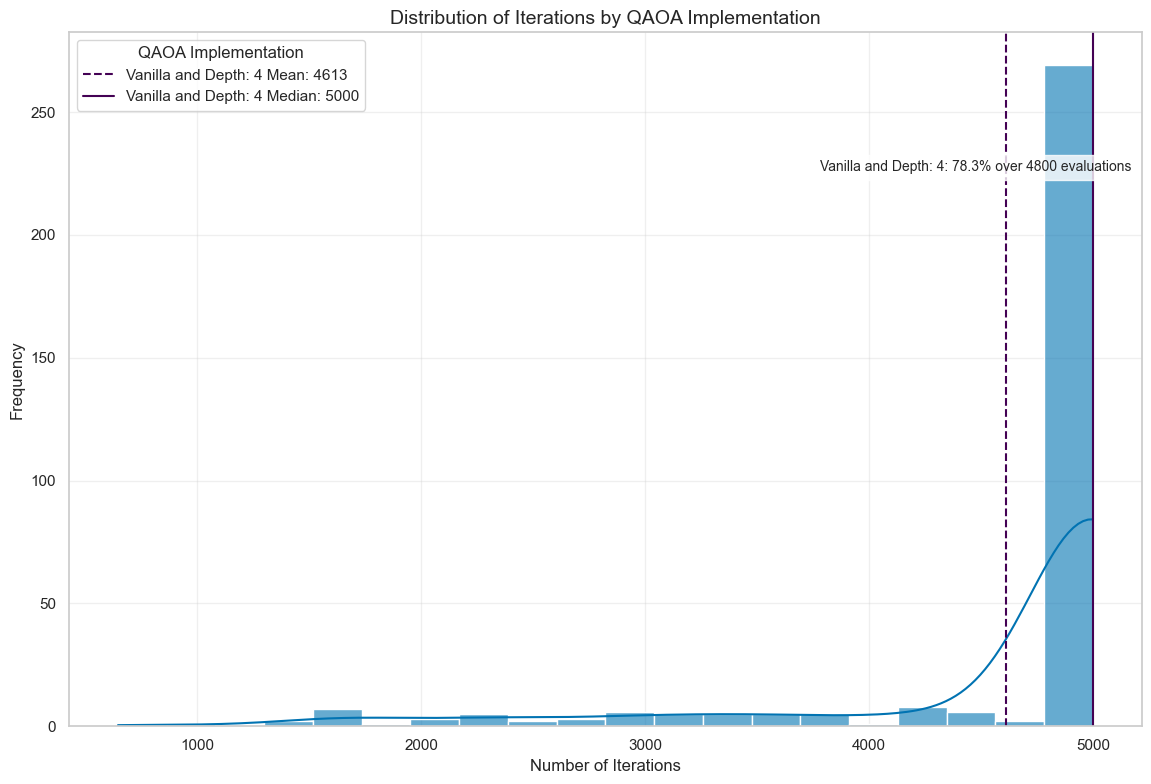

In [470]:
import seaborn as sns

# Create a visualization of the distribution of quantum function evaluations
import matplotlib.pyplot as plt

# Get the distribution per QAOA Implementation
plt.figure(figsize=(12, 8))

# Use a kernel density estimate plot to show the distribution
sns.histplot(
    data=subset, 
    x='Iterations',
    hue='QAOA Implementation',
    bins=20,
    kde=True,
    alpha=0.6
)

# Add vertical lines for the means of each group
for impl, color in zip(subset['QAOA Implementation'].unique(), plt.cm.viridis(np.linspace(0, 1, len(subset['QAOA Implementation'].unique())))):
    mean_evals = subset[subset['QAOA Implementation'] == impl]['Iterations'].mean()
    median_evals = subset[subset['QAOA Implementation'] == impl]['Iterations'].median()
    plt.axvline(x=mean_evals, color=color, linestyle='--', 
                label=f'{impl} Mean: {mean_evals:.0f}')
    plt.axvline(x=median_evals, color=color, linestyle='-', 
                label=f'{impl} Median: {median_evals:.0f}')
                # Calculate and display statistics for each implementation
    for impl in sorted(subset['QAOA Implementation'].unique()):
        eval_data = subset[subset['QAOA Implementation'] == impl]['Iterations']
        pct_high = (eval_data > 4999).mean() * 100
        plt.text(0.7, 0.8 - sorted(subset['QAOA Implementation'].unique()).index(impl) * 0.05, 
                    f"{impl}: {pct_high:.1f}% over 4800 evaluations",
                    transform=plt.gca().transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))
# Customize the plot
plt.title('Distribution of Iterations by QAOA Implementation', fontsize=14)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='QAOA Implementation')

plt.tight_layout()
plt.savefig('func_evals_distribution.pdf', bbox_inches='tight')
plt.show()


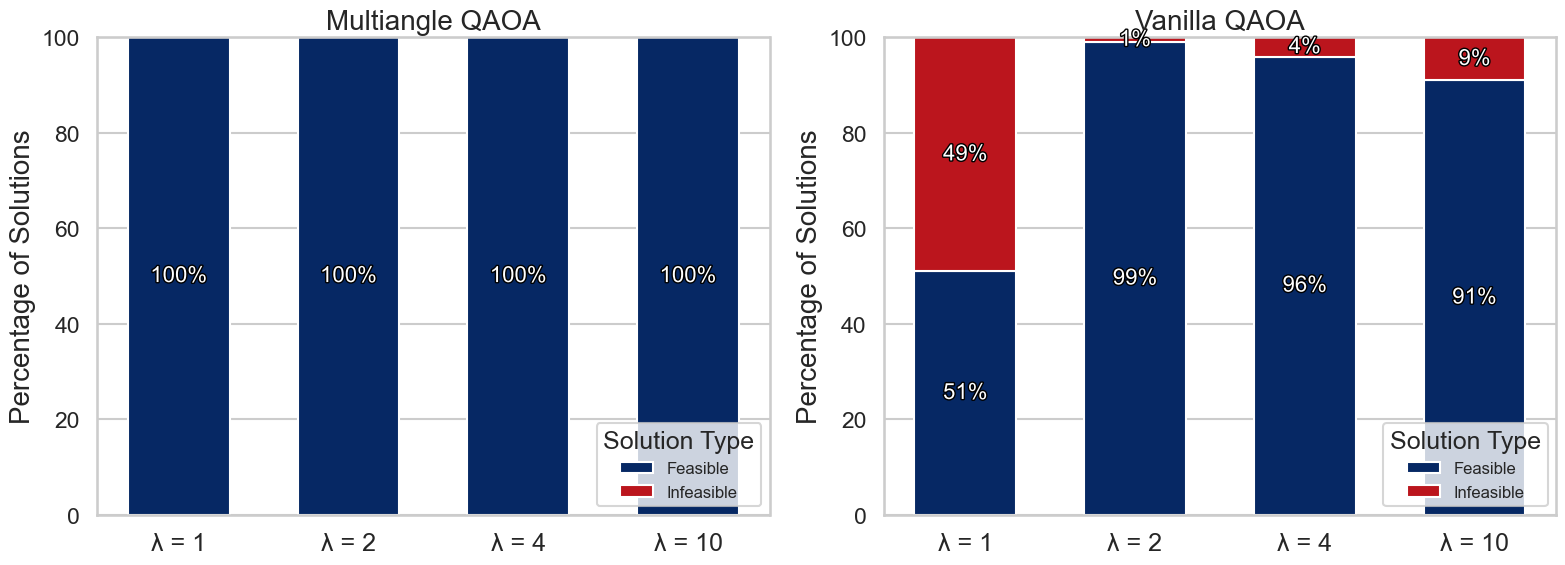

In [471]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patheffects as path_effects

# --- Data prep ---
df_analysis = results_lagrange.copy()
df_analysis = df_analysis[df_analysis['warm_start']==False]
# Group by config and count
grouped = df_analysis.groupby(['qaoa_variant', 'lagrangian_multiplier', 'infeasible']).size().reset_index(name='count')

# Create two separate dataframes for multiangle and vanilla
grouped_multiangle = grouped[grouped['qaoa_variant'] == 'multiangle']
grouped_vanilla = grouped[grouped['qaoa_variant'] == 'vanilla']

# Process each variant separately
def process_variant_data(data):
    # Pivot to wide format
    pivot_df = data.pivot_table(
        index=['lagrangian_multiplier'],
        columns='infeasible',
        values='count',
        fill_value=0
    ).reset_index()
    
    # Rename for clarity    
    pivot_df.rename(columns={False: 'feasible', True: 'infeasible'}, inplace=True)
    
    # Calculate percentages
    pivot_df['total'] = pivot_df['feasible'] + pivot_df['infeasible']
    pivot_df['feasible_pct'] = pivot_df['feasible'] / pivot_df['total'] * 100
    pivot_df['infeasible_pct'] = pivot_df['infeasible'] / pivot_df['total'] * 100
    
    return pivot_df

# Handle the case where one variant might not have any infeasible results
if 'True' not in grouped_multiangle['infeasible'].values:
    # Add a placeholder row with infeasible=True if none exists
    placeholder_row = grouped_multiangle.iloc[0].copy()
    placeholder_row['infeasible'] = True
    placeholder_row['count'] = 0
    grouped_multiangle = pd.concat([grouped_multiangle, pd.DataFrame([placeholder_row])])

pivot_multiangle = process_variant_data(grouped_multiangle)
pivot_vanilla = process_variant_data(grouped_vanilla)

# --- Create a figure with two subplots side by side ---
sns.set_theme(style="whitegrid", context="talk")
colors = {'Feasible': "#062864", 'Infeasible': "#BB151D"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper function to plot a single variant
def plot_variant(pivot_df, ax, title):
    x = np.arange(len(pivot_df))
    width = 0.6
    
    # Plot feasible bar base
    bars1 = ax.bar(x, pivot_df['feasible_pct'], width, label='Feasible', color=colors['Feasible'])
    
    # Plot infeasible on top
    bars2 = ax.bar(x, pivot_df['infeasible_pct'], width, bottom=pivot_df['feasible_pct'], 
                   label='Infeasible', color=colors['Infeasible'])
    
    # Add percentage labels
    for i, row in pivot_df.iterrows():
        if row['feasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] / 2, 
                f"{row['feasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        if row['infeasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] + row['infeasible_pct'] / 2, 
                f"{row['infeasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    
    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels([f"λ = {d}" for d in pivot_df['lagrangian_multiplier']], fontsize=18)
    ax.set_ylabel("Percentage of Solutions", fontsize=20)
    ax.set_ylim(0, 100)
    ax.set_title(title, fontsize=20)
    
    # Add legend
    ax.legend(title="Solution Type", fontsize=12, title_fontsize=18, loc='lower right')

# Plot each variant on its respective axis
plot_variant(pivot_multiangle, ax1, "Multiangle QAOA")
plot_variant(pivot_vanilla, ax2, "Vanilla QAOA")

plt.tight_layout()
plt.savefig('lagrangian_feasible_percent.pdf', bbox_inches='tight')
plt.show()


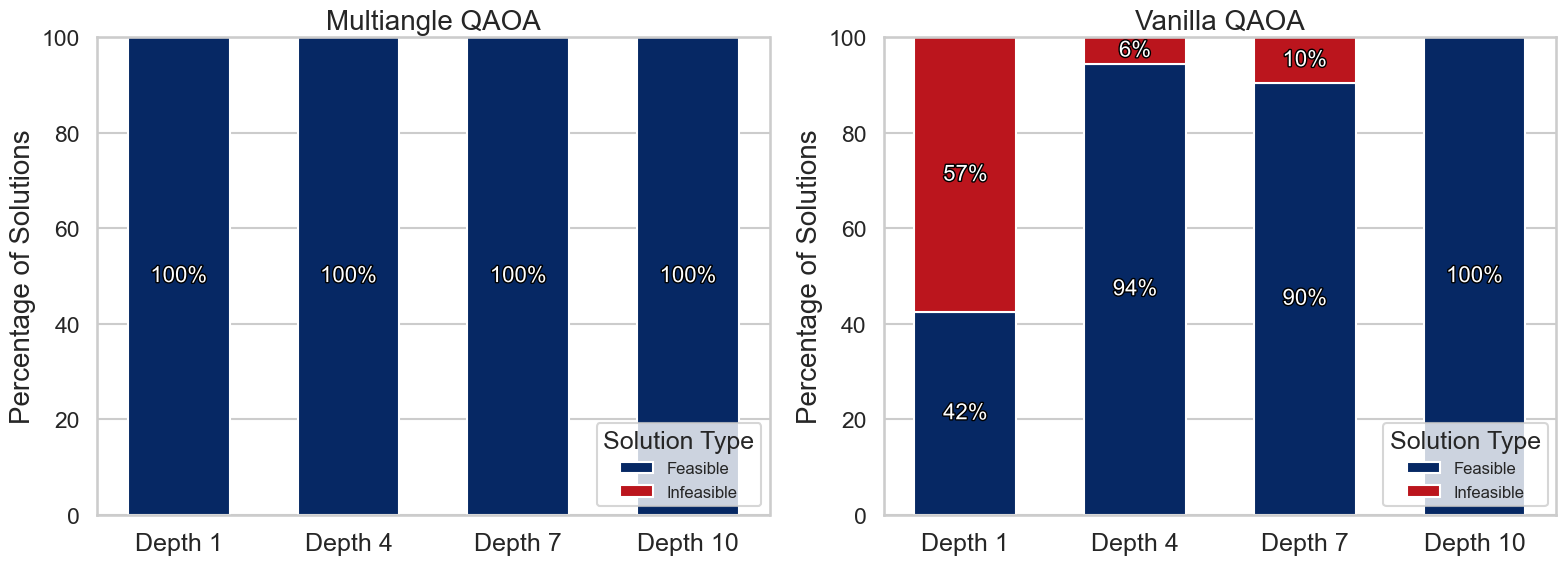

In [472]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Data prep ---
df_analysis = results.copy()
df_analysis = df_analysis[df_analysis['warm_start']==False]
df_analysis = df_analysis[df_analysis['backend_mode']=='statevector']

# Group by config and count
grouped = df_analysis.groupby(['qaoa_variant', 'depth', 'infeasible']).size().reset_index(name='count')

# Create two separate dataframes for multiangle and vanilla
grouped_multiangle = grouped[grouped['qaoa_variant'] == 'multiangle']
grouped_vanilla = grouped[grouped['qaoa_variant'] == 'vanilla']

# Process each variant separately
def process_variant_data(data):
    # Pivot to wide format
    pivot_df = data.pivot_table(
        index=['depth'],
        columns='infeasible',
        values='count',
        fill_value=0
    ).reset_index()
    # Rename for clarity    
    pivot_df.rename(columns={False: 'feasible', True: 'infeasible'}, inplace=True)
    # Calculate percentages
    pivot_df['total'] = pivot_df['feasible'] + pivot_df['infeasible']
    pivot_df['feasible_pct'] = pivot_df['feasible'] / pivot_df['total'] * 100
    pivot_df['infeasible_pct'] = pivot_df['infeasible'] / pivot_df['total'] * 100
    
    return pivot_df

# Handle the case where multiangle might not have any infeasible results
if 'True' not in grouped_multiangle['infeasible'].values:
    # Add a placeholder row with infeasible=True if none exists
    placeholder_row = grouped_multiangle.iloc[0].copy()
    placeholder_row['infeasible'] = True
    placeholder_row['count'] = 0
    grouped_multiangle = pd.concat([grouped_multiangle, pd.DataFrame([placeholder_row])])

pivot_multiangle = process_variant_data(grouped_multiangle)
pivot_vanilla = process_variant_data(grouped_vanilla)
import matplotlib.patheffects as path_effects
# --- Create a figure with two subplots side by side ---
sns.set_theme(style="whitegrid", context="talk")
colors = {'Feasible': "#062864", 'Infeasible': "#BB151D"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper function to plot a single variant
def plot_variant(pivot_df, ax, title):
    x = np.arange(len(pivot_df))
    width = 0.6
    
    # Plot feasible bar base
    bars1 = ax.bar(x, pivot_df['feasible_pct'], width, label='Feasible', color=colors['Feasible'])
    
    # Plot infeasible on top
    bars2 = ax.bar(x, pivot_df['infeasible_pct'], width, bottom=pivot_df['feasible_pct'], 
                   label='Infeasible', color=colors['Infeasible'])
    
    # Add percentage labels
    for i, row in pivot_df.iterrows():
        if row['feasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] / 2, 
                f"{row['feasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        if row['infeasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] + row['infeasible_pct'] / 2, 
                f"{row['infeasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    
    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels([f"Depth {d:.0f}" for d in pivot_df['depth']], fontsize=18)
    ax.set_ylabel("Percentage of Solutions", fontsize=20)
    ax.set_ylim(0, 100)
    ax.set_title(title, fontsize=20)
    
    # Add legend
    ax.legend(title="Solution Type", fontsize=12, title_fontsize=18, loc='lower right')

# Plot each variant on its respective axis
plot_variant(pivot_multiangle, ax1, "Multiangle QAOA")
plot_variant(pivot_vanilla, ax2, "Vanilla QAOA")

plt.tight_layout()
plt.savefig('CS_feasible_percent.pdf', bbox_inches='tight')
plt.show()


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\692300707.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\692300707.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[1].get_xticklabels()])


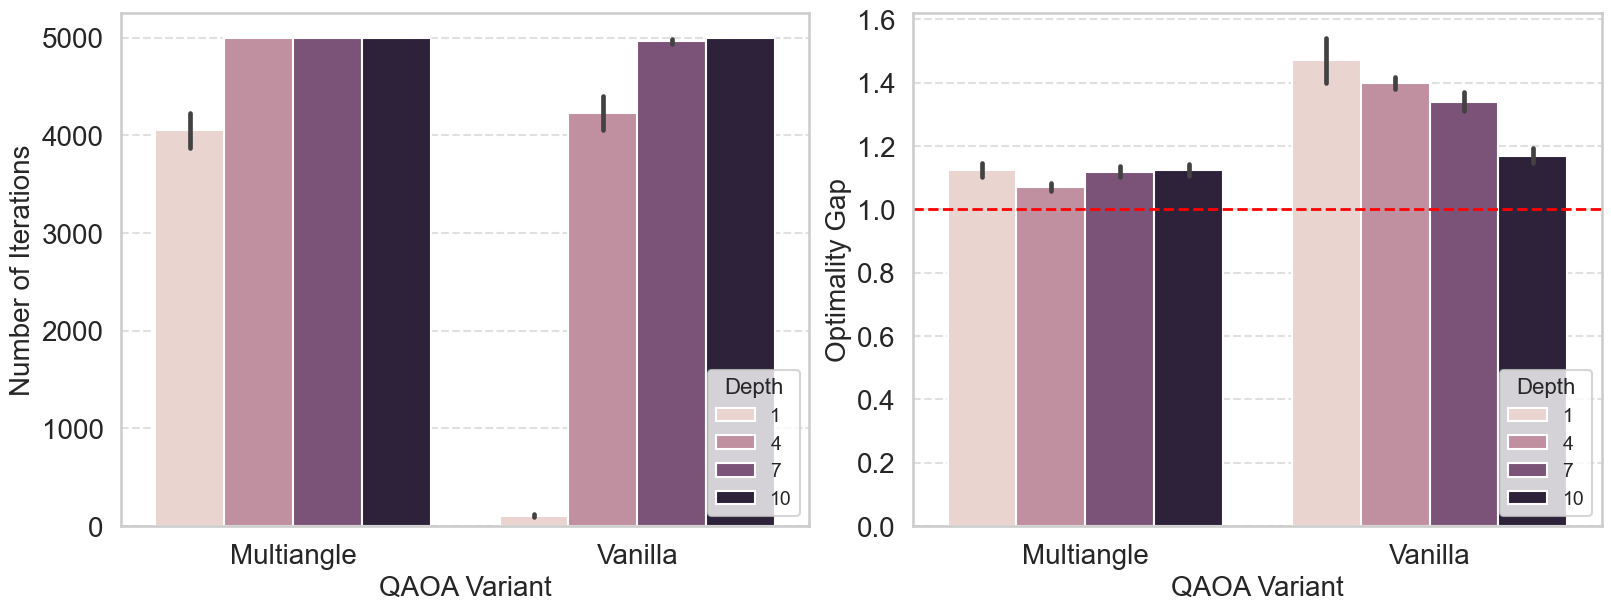

In [473]:
import matplotlib.pyplot as plt
import seaborn as sns
df = results.copy()


df = df[df['warm_start'] == False]
df = df[df['infeasible'] == False]
df = df[df['backend_mode'] =='statevector']
df['depth'] = df['depth'].astype(int)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# First subplot - Quantum Function Evaluations
sns.barplot(data=df, x="qaoa_variant", y="Iterations", hue="depth", ax=axes[0])
axes[0].set_xlabel("QAOA Variant", fontsize=20)
axes[0].set_ylabel("Number of Iterations", fontsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].legend(title="Depth", title_fontsize=16, fontsize=14, loc='lower right')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[0].get_xticklabels()])

# Second subplot - Solution Quality
sns.barplot(data=df, x="qaoa_variant", y="ratio", hue="depth", ax=axes[1])
axes[1].set_xlabel("QAOA Variant", fontsize=20)
axes[1].set_ylabel("Optimality Gap", fontsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].legend(title="Depth", title_fontsize=16, fontsize=14, loc='lower right')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[1].get_xticklabels()])

# Add a horizontal red line at y=1 for the ratio plot to indicate optimal solution
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2)

plt.savefig('CS_metrics.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Table showing summary statistics for quantum function evaluations by QAOA variant and depth
summary_stats = df.groupby(['qaoa_variant', 'depth'])[['Iterations', 'ratio']].agg({
    'Iterations': ['mean', 'std', 'min', 'max', 'count'],
    'ratio': ['mean', 'std', 'min', 'max']
})

# Format the table for better readability
summary_stats = summary_stats.round(2)

# Calculate overall average and standard deviation for each variant regardless of depth
overall_stats = df.groupby(['qaoa_variant'])[['Iterations', 'ratio']].agg({
    'Iterations': ['mean', 'std'],
    'ratio': ['mean', 'std']
}).round(2)


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\4113818926.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], fontsize=18)


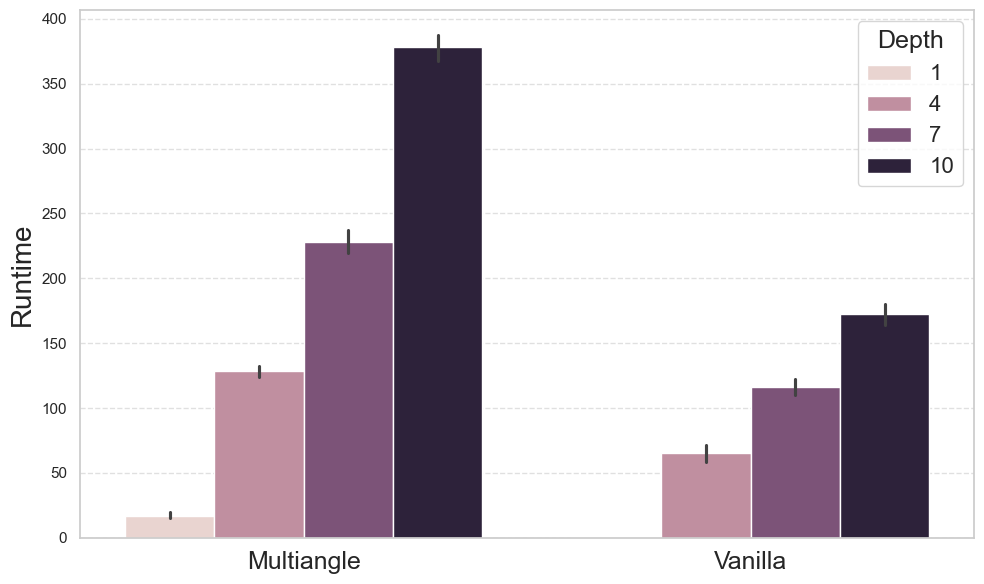

In [484]:
#---------- Graph size 6 w infeasible-------------
# Filter only graph size 6 data

df_size_6 = results[results['graph_size'] == 6].copy()
df_size_6 = df_size_6[df_size_6['warm_start']==False]
df_size_6 = df_size_6[df_size_6['backend_mode']=='statevector']
#df_size_6 = df_size_6[df_size_6['infeasible']==False]
# Create figure
plt.figure(figsize=(10, 6))

# Set theme
sns.set_theme(style="whitegrid", palette="colorblind")

# Plot data
sns.barplot(data=df_size_6, x="qaoa_variant", y="time_elapsed", hue="depth")

# Add horizontal line at ratio=1
#plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Customize plot
plt.ylabel("Runtime", fontsize=20)
plt.legend(title="Depth", title_fontsize=18, fontsize=16)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xlabel(None)
ax = plt.gca()
ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], fontsize=18)



plt.tight_layout()
plt.savefig('CS_infeasible_smallgraph_runtimes.pdf',bbox_inches='tight')

plt.show()

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1195103035.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1195103035.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 1].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1195103035.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\1195103035.py:60: UserWarning: set_ticklabels() sh

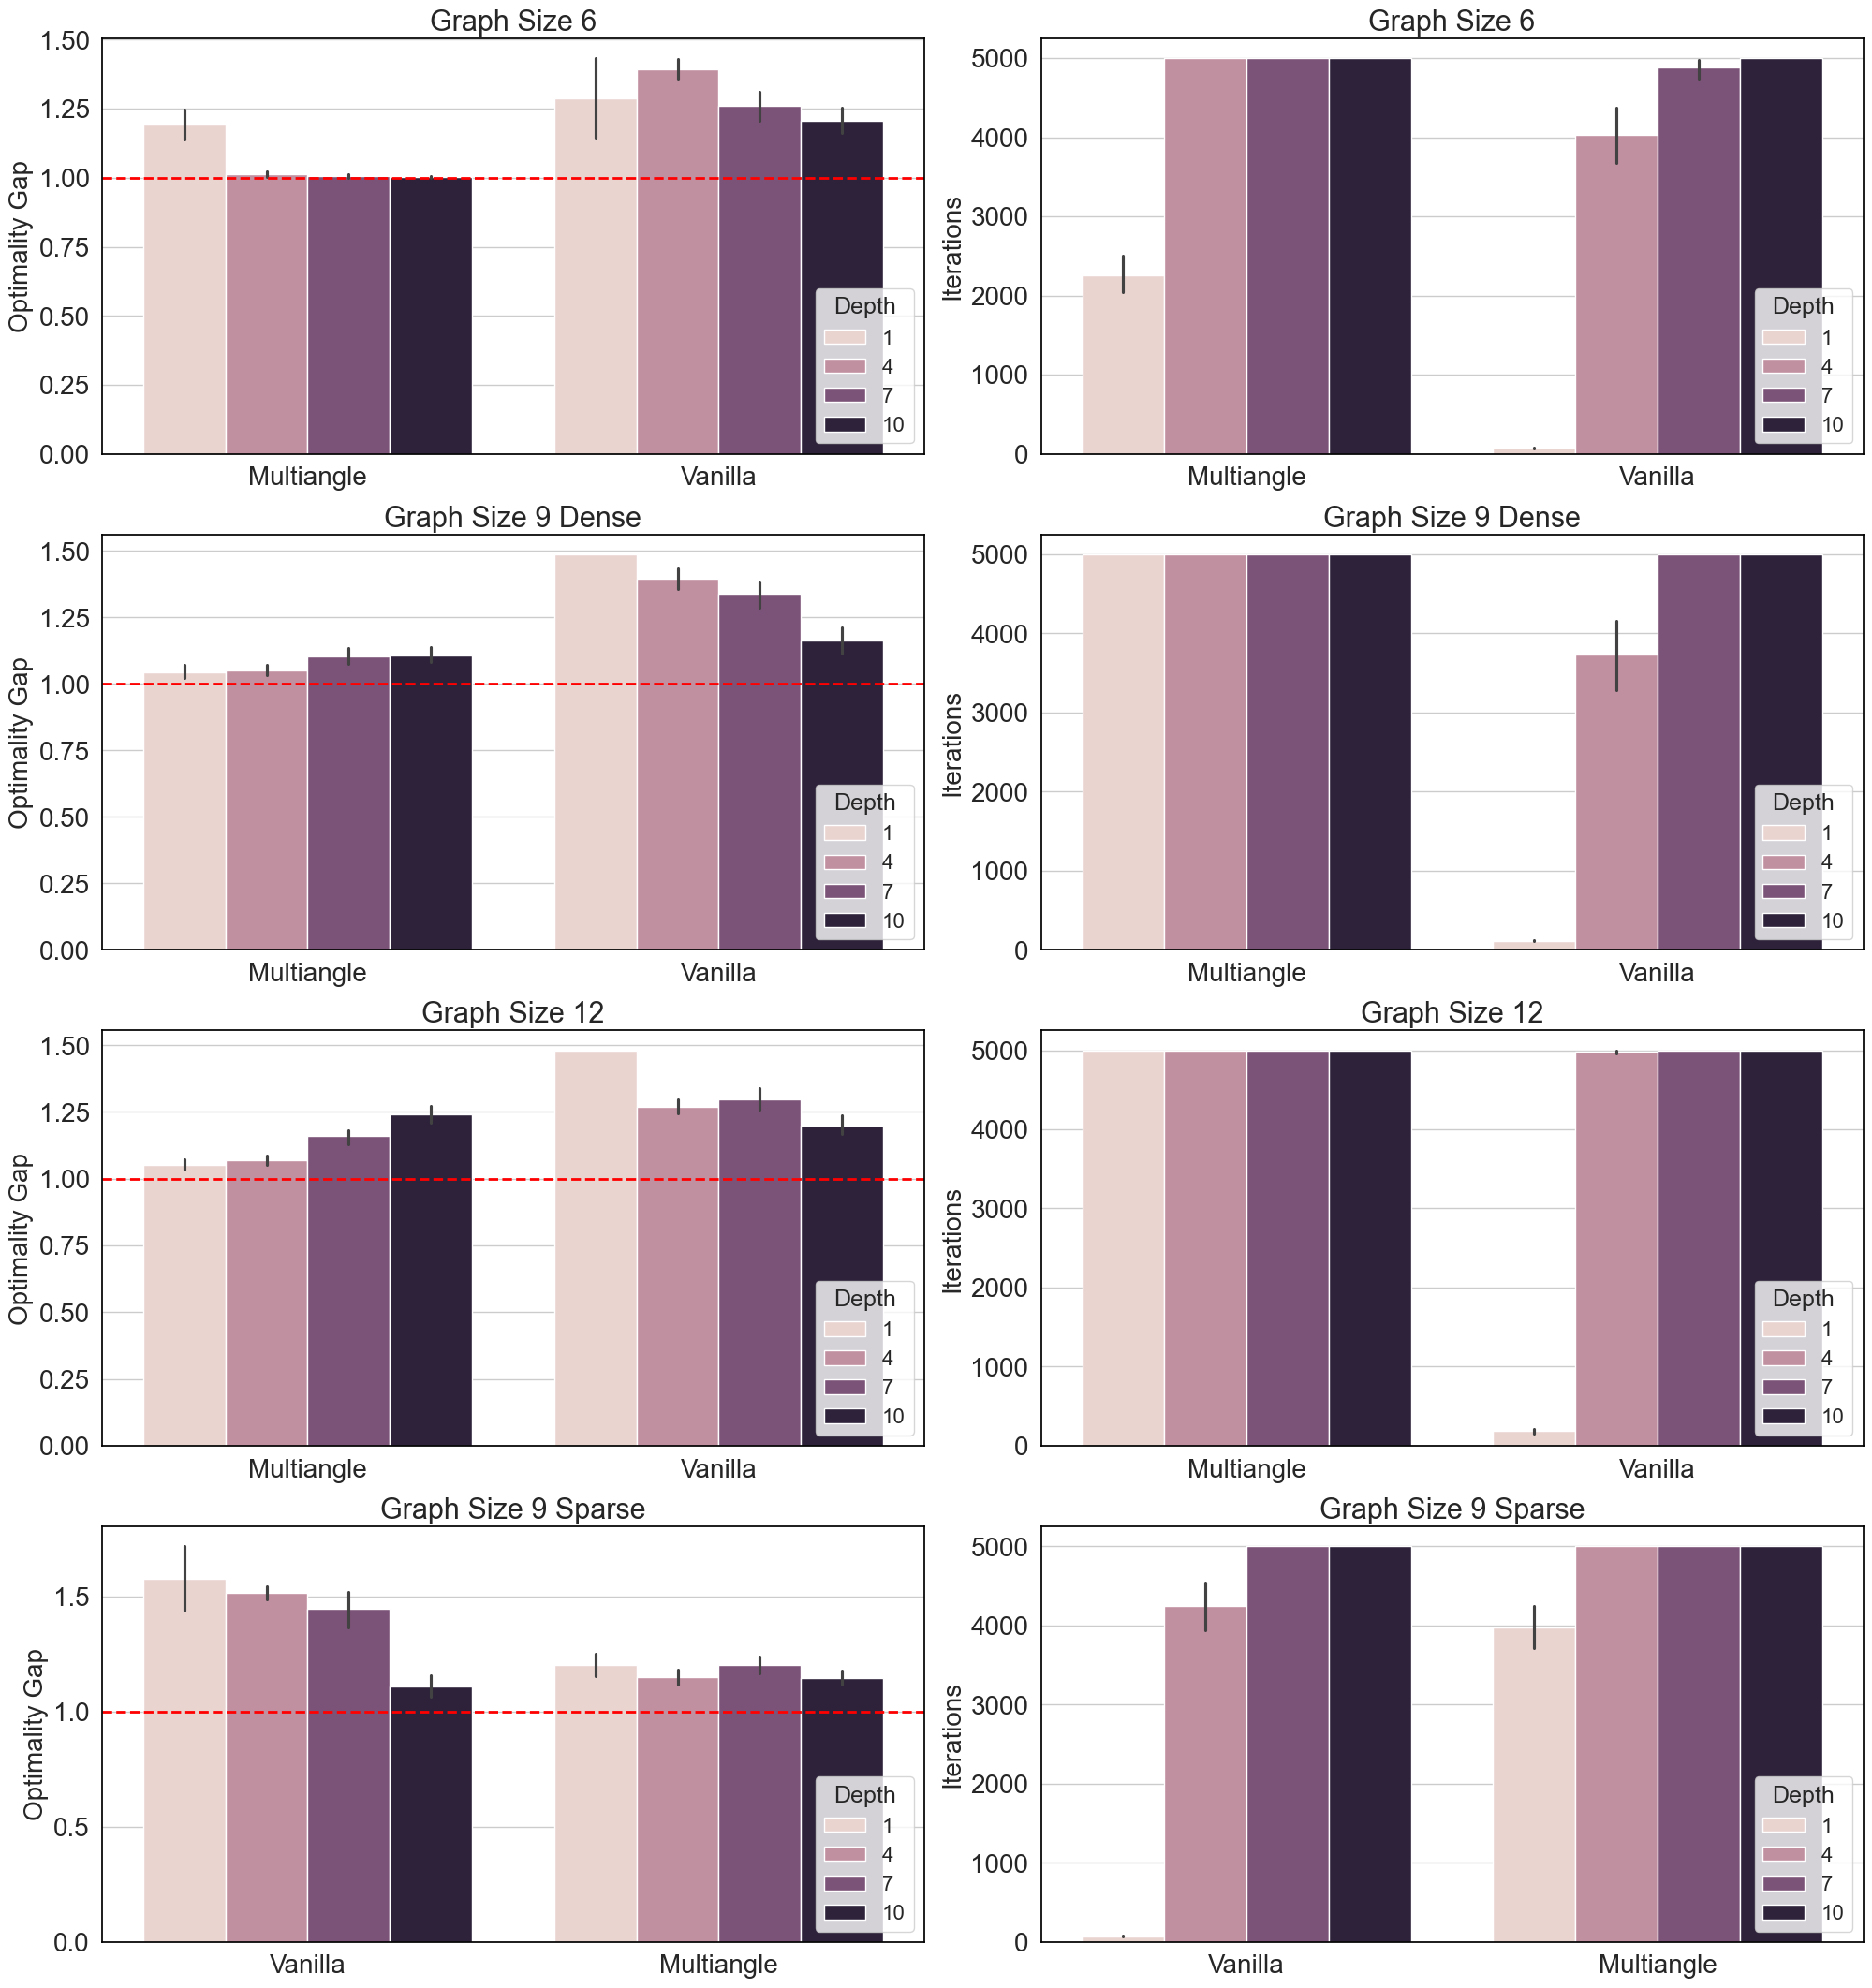

count       400
unique        2
top       False
freq        385
Name: infeasible, dtype: object
                    count     mean          std     min      25%     50%  \
qaoa_variant depth                                                         
multiangle   1       50.0  3976.38   988.557822  1995.0  3291.50  3799.0   
             4       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             7       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             10      50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
vanilla      1       50.0    75.06    26.049725    58.0    68.00    71.0   
             4       50.0  4245.74  1094.393874   807.0  3671.75  5000.0   
             7       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             10      50.0  5000.00     0.000000  5000.0  5000.00  5000.0   

                       75%     max  
qaoa_variant depth                  
multiangle   1      5000.0  5000.0  
             4      5000.0  5000

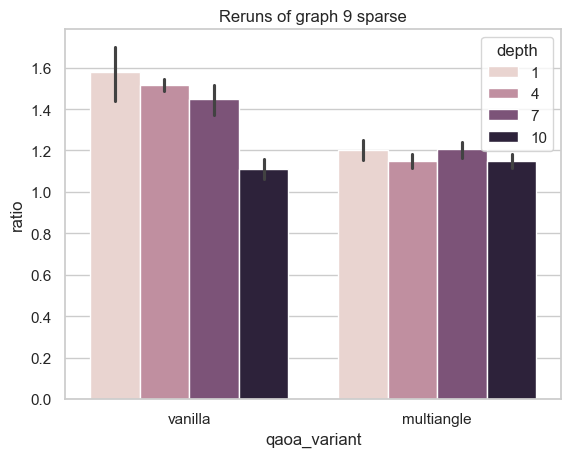

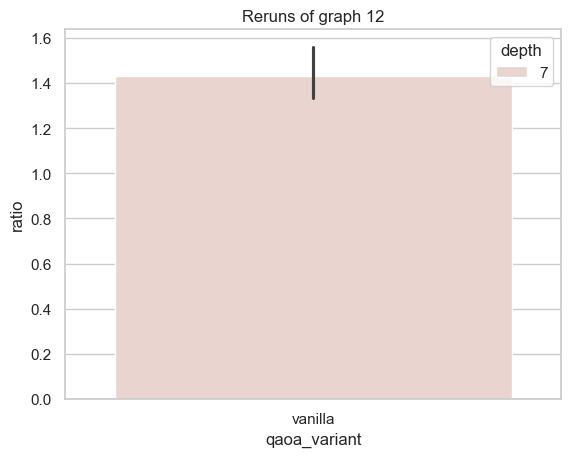

In [482]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a copy of results to work with
df = results.copy()
df = df[df['infeasible'] == False]  # Filter out infeasible solutions
df = df[df['warm_start'] == False]  # Filter out warm start solutions
df = df[df['backend_mode'] == 'statevector']




df['depth'] = df['depth'].astype(int)
# Get unique graph names
graph_names = df['graph_name'].unique()

# Create a 4x2 figure for side-by-side comparisons
fig, axes = plt.subplots(4, 2, figsize=(20, 22))

# Left column: Optimality Gap (ratio)
# Right column: Quantum Function Evaluations
for i, graph in enumerate(graph_names):
    # Filter data for this graph
    graph_df = df[df['graph_name'] == graph]
    
    # Get graph size for the title
    graph_size = graph_df['graph_size'].iloc[0]
    
    # Determine graph title
    if graph_size == 9:
        if graph == '>>graph6<<HmzffJz':
            graph_title = f"Graph Size {graph_size:.0f} Dense"
        else:
            graph_title = f"Graph Size {graph_size:.0f} Sparse"
    else:
        graph_title = f"Graph Size {graph_size:.0f}"
    
    # Left plot: Optimality Gap (ratio)
    sns.barplot(data=graph_df, x="qaoa_variant", y="ratio", hue="depth", ax=axes[i, 0])
    axes[i, 0].set_title(f"{graph_title}", fontsize=22)
    axes[i, 0].set_ylabel("Optimality Gap", fontsize=20)
    axes[i, 0].tick_params(axis='both', labelsize=20)
    axes[i, 0].axhline(y=1, color='red', linestyle='--', linewidth=2)
    axes[i, 0].set_xlabel("")
    axes[i, 0].legend(title="Depth", title_fontsize=18, fontsize=16, loc="lower right")
    axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
    axes[i, 0].spines['top'].set_color('black')
    axes[i, 0].spines['right'].set_color('black')
    axes[i, 0].spines['bottom'].set_color('black')
    axes[i, 0].spines['left'].set_color('black')
    
    # Right plot: QFE
    sns.barplot(data=graph_df, x="qaoa_variant", y="Iterations", hue="depth", ax=axes[i, 1])
    axes[i, 1].set_title(f"{graph_title}" , fontsize=22)
    axes[i, 1].set_ylabel("Iterations", fontsize=20)
    axes[i, 1].tick_params(axis='both', labelsize=20)
    axes[i, 1].set_xlabel("")
    axes[i, 1].legend(title="Depth", title_fontsize=18, fontsize=16, loc="lower right")
    axes[i, 1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 1].get_xticklabels()])
    axes[i, 1].spines['top'].set_color('black')
    axes[i, 1].spines['right'].set_color('black')
    axes[i, 1].spines['bottom'].set_color('black')
    axes[i, 1].spines['left'].set_color('black')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for suptitle

# Save figure
plt.savefig('CS_combined_graphs_comparison.pdf', bbox_inches='tight')

plt.show()


check_data =pd.read_csv("results_rerun_sparse_statevector.csv")
g = problem.get_erdos_renyi_graphs_paper1()[3]

check_data_12 = pd.read_csv("results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{7},'warm_start'{False},'problem_type'{'minvertexcover'}}.csv")
check_data.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
check_data_12.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
# create a networkx graph from the rustworkx graph
G = nx.Graph(list(g.edge_list()))
graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
solver = MinVertexCoverSolver(g, 'minvertexcover')
mask = check_data['graph_name'] == graph6_string
check_data.loc[check_data['graph_name'] == graph6_string, 'infeasible']= check_data.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
mask_ws = (check_data['graph_name'] == graph6_string) & (check_data['warm_start'] == True)
check_data.loc[mask_ws, 'ws_value'] = check_data.loc[mask_ws, 'hamming_string'].apply(
    lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0])
print(check_data['infeasible'].describe())
print(check_data.groupby(['qaoa_variant', 'depth'])['Iterations'].describe())
check_data = check_data[check_data['infeasible']==False]
fig = plt.plot()
sns.barplot(data=check_data, x= 'qaoa_variant', y='ratio', hue='depth')
plt.title('Reruns of graph 9 sparse')
plt.show()


g = problem.get_erdos_renyi_graphs_paper1()[2]

check_data = check_data_12
# create a networkx graph from the rustworkx graph
G = nx.Graph(list(g.edge_list()))
graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
solver = MinVertexCoverSolver(g, 'minvertexcover')
mask = check_data['graph_name'] == graph6_string
check_data.loc[check_data['graph_name'] == graph6_string, 'infeasible']= check_data.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
mask_ws = (check_data['graph_name'] == graph6_string) & (check_data['warm_start'] == True)
check_data.loc[mask_ws, 'ws_value'] = check_data.loc[mask_ws, 'hamming_string'].apply(
    lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0])

fig = plt.plot()
sns.barplot(data=check_data, x= 'qaoa_variant', y='ratio', hue='depth')
plt.title('Reruns of graph 12')
plt.show()



Combined both 40000 iteration datasets
0      >>graph6<<Hh_iS_u
1      >>graph6<<Hh_iS_u
2      >>graph6<<Hh_iS_u
3      >>graph6<<Hh_iS_u
4      >>graph6<<Hh_iS_u
             ...        
395    >>graph6<<Hh_iS_u
396    >>graph6<<Hh_iS_u
397    >>graph6<<Hh_iS_u
398    >>graph6<<Hh_iS_u
399    >>graph6<<Hh_iS_u
Name: graph_name, Length: 400, dtype: object


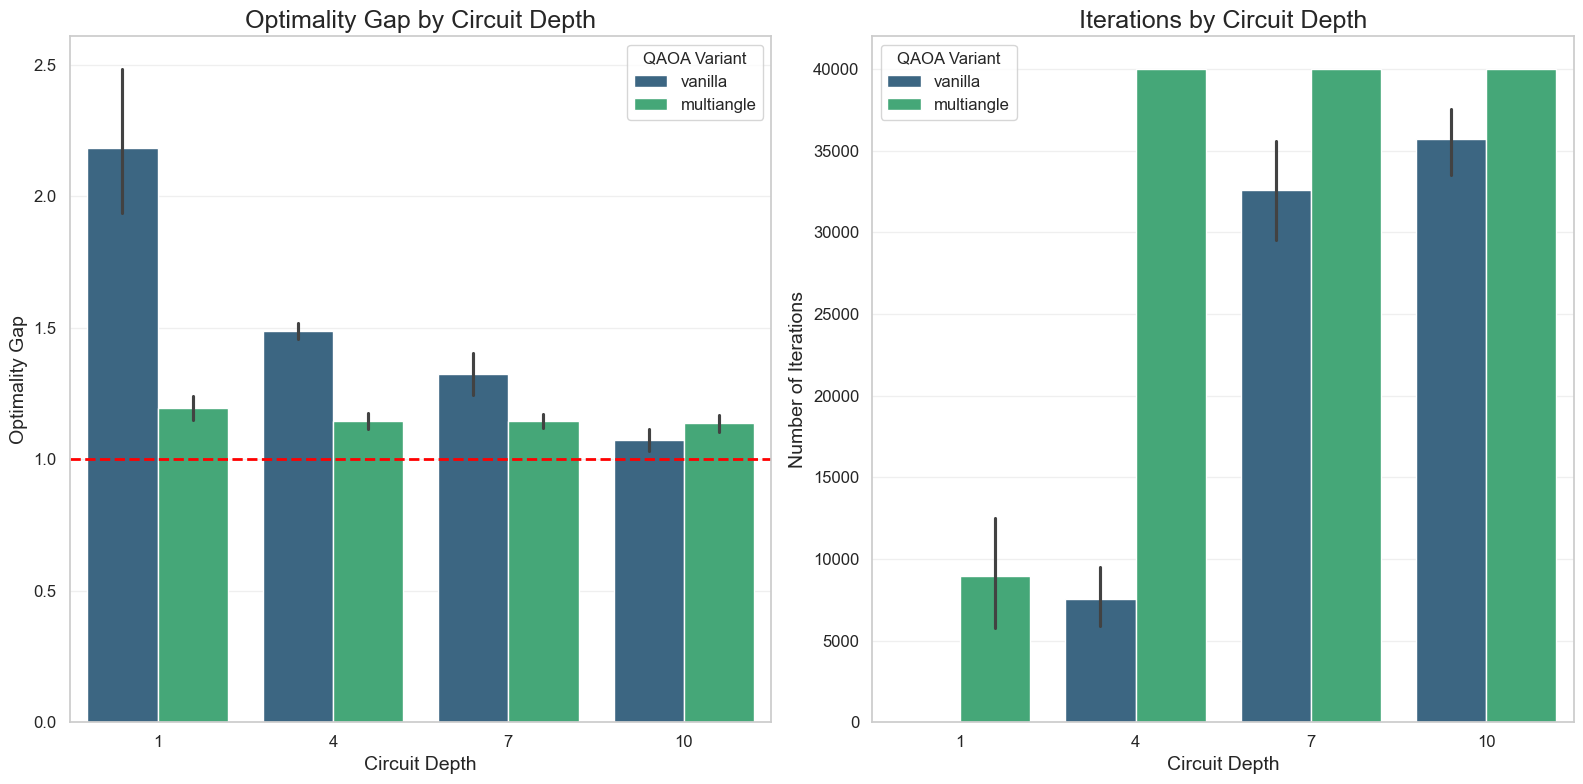

In [476]:
df_40000 = pd.read_csv('results_papergraph_{40000 iterations}.csv')

# Try to load and concatenate the sparse results if available
try:
    df_sparse_40000 = pd.read_csv('results_sparse_40000.csv')
    df_40000 = pd.concat([df_40000, df_sparse_40000], ignore_index=True)
    print("Combined both 40000 iteration datasets")
except FileNotFoundError:
    print("Only found main 40000 iterations dataset")
df_40000.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
print(df_40000['graph_name'])
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left subplot - Depth vs Ratio
sns.barplot(data=df_40000, x='depth', y='ratio', hue='qaoa_variant', ax=axes[0], palette='viridis')
axes[0].set_title('Optimality Gap by Circuit Depth', fontsize=18)
axes[0].set_xlabel('Circuit Depth', fontsize=14)
axes[0].set_ylabel('Optimality Gap', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(title='QAOA Variant', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')
# Add a red horizontal line at ratio=1 to indicate optimal solution
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2)

# Right subplot - Depth vs Iterations
sns.barplot(data=df_40000, x='depth', y='Iterations', hue='qaoa_variant', ax=axes[1], palette='viridis')
axes[1].set_title('Iterations by Circuit Depth', fontsize=18)
axes[1].set_xlabel('Circuit Depth', fontsize=14)
axes[1].set_ylabel('Number of Iterations', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(title='QAOA Variant', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('depth_40000_comparison.pdf', bbox_inches='tight')
plt.show()

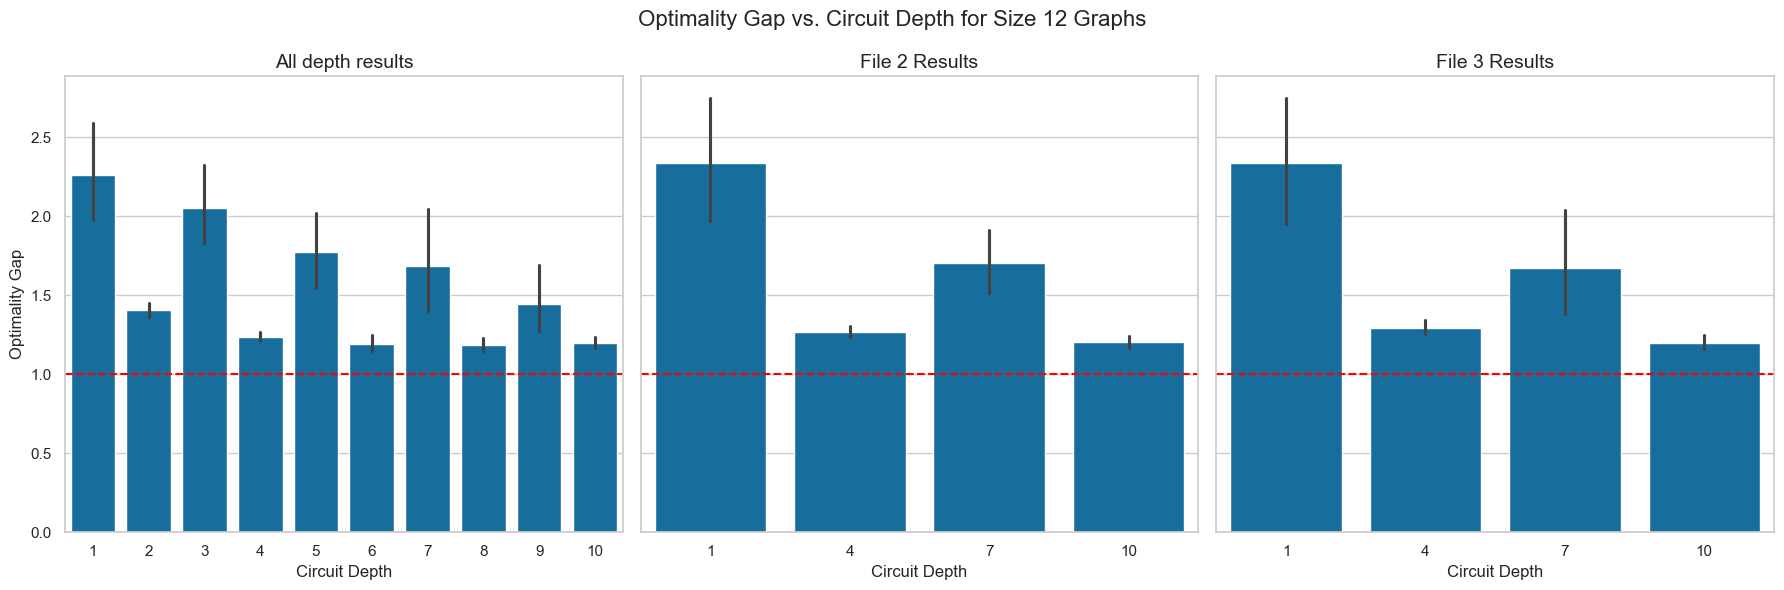

In [477]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Load the data files
df1 = pd.read_csv("results_size12_1.csv")
df2 = pd.read_csv("results_size12_2.csv")
df3 = pd.read_csv("results_size12_3.csv")

df4 = pd.read_csv("results_size12_alldepths.csv")
df1 = pd.concat([df1, df4])
# Add a source column to identify the file source
df1['source'] = 'File 1'
df2['source'] = 'File 2'
df3['source'] = 'File 3'

# Ensure depth is treated as a categorical variable for proper ordering on x-axis
df1['depth'] = df1['depth'].astype('category')
df2['depth'] = df2['depth'].astype('category')
df3['depth'] = df3['depth'].astype('category')

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each dataset
sns.barplot(data=df1, x='depth', y='ratio', ax=axes[0])
axes[0].set_title('All depth results', fontsize=14)
axes[0].set_xlabel('Circuit Depth', fontsize=12)
axes[0].set_ylabel('Optimality Gap', fontsize=12)
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=1.5)

sns.barplot(data=df2, x='depth', y='ratio', ax=axes[1])
axes[1].set_title('File 2 Results', fontsize=14)
axes[1].set_xlabel('Circuit Depth', fontsize=12)
axes[1].set_ylabel('', fontsize=12)  # Remove y-label for middle plot
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1.5)

sns.barplot(data=df3, x='depth', y='ratio', ax=axes[2])
axes[2].set_title('File 3 Results', fontsize=14)
axes[2].set_xlabel('Circuit Depth', fontsize=12)
axes[2].set_ylabel('', fontsize=12)  # Remove y-label for right plot
axes[2].axhline(y=1, color='red', linestyle='--', linewidth=1.5)

# Add a common title
plt.suptitle('Optimality Gap vs. Circuit Depth for Size 12 Graphs', fontsize=16)
plt.tight_layout()
plt.savefig('size12_comparison.pdf', bbox_inches='tight')
plt.show()

for >>graph6<<Emz_ the depths are                     count     mean          std     min      25%     50%  \
qaoa_variant depth                                                         
multiangle   1       50.0  2250.32   822.654723  1187.0  1752.50  2164.5   
             2       50.0  4965.74   179.413877  3853.0  5000.00  5000.0   
             3       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             4       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             5       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             6       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             7       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             8       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             9       50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
             10      50.0  5000.00     0.000000  5000.0  5000.00  5000.0   
vanilla      1       50.0    85.48    20.393316    65.

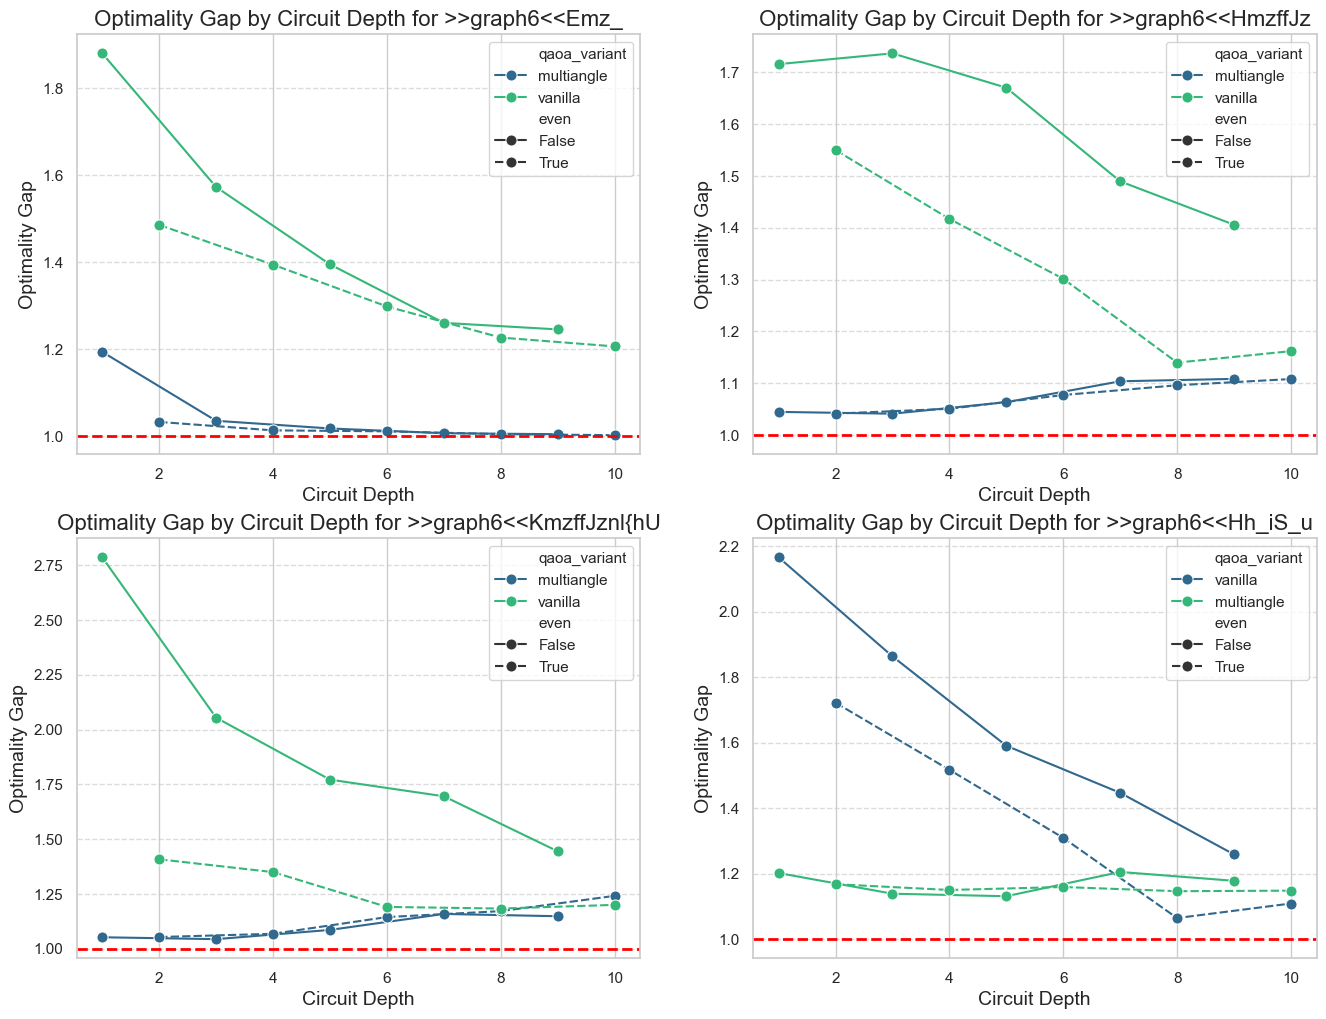

In [478]:
results_sparse_statevector = results[(results['backend_mode'] == 'statevector')&
                                                (results['warm_start'] == False) ]

depths = pd.concat([pd.read_csv('results_size12_alldepths.csv'),
                          pd.read_csv('results_6_9_alldepths.csv'),
                          pd.read_csv('results_sparse_alldepths.csv'),
                          pd.read_csv('results_ma_2_3_5_6.csv'),
                          pd.read_csv('results_ma_8_9.csv')], ignore_index=True)
#rename quanutm_func_evals to Iterations
depths.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
combined = pd.concat([results_sparse_statevector, depths], ignore_index=True)
# Create a bar plot for the combined results
from matplotlib import pyplot as plt
plt, ax = plt.subplots(2,2, figsize=(16, 12))


combined['even'] = combined['depth'] % 2 == 0
for i,graph_name in enumerate(combined['graph_name'].unique()):
    graph_data = combined[combined['graph_name'] == graph_name].copy()
    print(f"for {graph_name} the depths are {graph_data.groupby(['qaoa_variant','depth'])['Iterations'].describe()}")

    index_1 = i//2
    index_2 = i%2
    sns.lineplot(data=graph_data, x='depth', y='ratio', hue=graph_data['qaoa_variant'],style='even' ,palette='viridis',ax=ax[index_1, index_2], errorbar=None, marker='o', markersize=8)
    ax[index_1,index_2].axhline(y=1, color='red', linestyle='--', linewidth=2)
    ax[index_1,index_2].set_title(f'Optimality Gap by Circuit Depth for {graph_name}', fontsize=16)
    ax[index_1,index_2].set_xlabel('Circuit Depth', fontsize=14)
    ax[index_1,index_2].set_ylabel('Optimality Gap', fontsize=14)
    ax[index_1,index_2].grid(axis='y', linestyle='--', alpha=0.7)




In [ ]:

df = combined.copy()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Instructions ===========================================================
# • Put your dataframe into a variable called `df`.
#     Required columns: depth, ratio, quantum_func_evals, graph_name
# • Run this cell. It will:
#     1. Split each graph_name’s data into odd‑depth and even‑depth runs.
#     2. Compute the *improvement* (drop in ratio) between depth d‑2 and d.
#     3. For up to four graph_name values, draw a 2‑column grid:
#           left  = odd‑depth improvements,
#           right = even‑depth improvements.
#     4. A vertical dashed line marks the first depth where mean
#        quantum_func_evals ≥ 4900.
# ---------------------------------------------------------------------------

THRESHOLD_QFE = 4900          # avg quantum_func_evals marker
MAX_GRAPHS    = 4             # “4× times” → up to four graph instances

try:
    df
except NameError:
    print(
        "⚠️  Variable `df` not found.\n"
        "Load your dataframe and name it `df`, then run this cell."
    )
else:

    # --- Aggregate by depth -------------------------------------------------
    grouped = (df
               .groupby(["graph_name", "depth"], as_index=False)
               .agg(avg_ratio=("ratio", "mean"),
                    avg_qfe=("Iterations", "mean"))
               )

    def build_improvements(sub, depths):
        """Return DataFrame [depth -> improvement] given a depth list."""
        depth2ratio = sub.set_index("depth")["avg_ratio"]
        rows = []
        for d0, d1 in zip(depths[:-1], depths[1:]):
            if d0 in depth2ratio and d1 in depth2ratio:
                # positive improvement = reduction in ratio
                rows.append((d1, depth2ratio[d0] - depth2ratio[d1]))
        return pd.DataFrame(rows, columns=["depth", "improvement"])

    # --- Select up to MAX_GRAPHS distinct graph_names ----------------------
    graph_names = sorted(grouped["graph_name"].unique())[:MAX_GRAPHS]
    n_graphs    = len(graph_names)

    fig, axes = plt.subplots(nrows=n_graphs, ncols=2,
                             figsize=(12, 3 * n_graphs),
                             sharex=True, sharey=True,
                             constrained_layout=True)

    if n_graphs == 1:
        axes = np.array([axes])  # ensure 2‑D indexing

    for row_idx, gname in enumerate(graph_names):
        sub = grouped[grouped["graph_name"] == gname]

        # Odd & even depth sequences
        odd_depths  = np.arange(1, 11, 2)
        even_depths = np.arange(2, 11, 2)

        odd_df  = build_improvements(sub, odd_depths)
        even_df = build_improvements(sub, even_depths)

        # Locate QFE threshold depth
        depth_cross = (
            sub.loc[sub["avg_qfe"] >= THRESHOLD_QFE, "depth"].min()
            if (sub["avg_qfe"] >= THRESHOLD_QFE).any() else None
        )

        # --- Plot odd improvements (left) ---------------------------------
        ax_odd = axes[row_idx, 0]
        if not odd_df.empty:
            ax_odd.plot(odd_df["depth"], odd_df["improvement"],
                        marker='o', label="Odd depths 1→3→…")
        if depth_cross is not None:
            ax_odd.axvline(depth_cross, linestyle='--',
                           label=f"⟨qfe⟩≥{THRESHOLD_QFE} @d={depth_cross}")

        ax_odd.set_title(f"{gname} – Odd")
        ax_odd.set_ylabel("Δ ratio (positive = better)")
        ax_odd.grid(True)
        ax_odd.set_xticks(range(1, 11))

        # --- Plot even improvements (right) -------------------------------
        ax_even = axes[row_idx, 1]
        if not even_df.empty:
            ax_even.plot(even_df["depth"], even_df["improvement"],
                         marker='s', label="Even depths 2→4→…")
        if depth_cross is not None:
            ax_even.axvline(depth_cross, linestyle='--')

        ax_even.set_title(f"{gname} – Even")
        ax_even.grid(True)
        ax_even.set_xticks(range(1, 11))

        # Legend only on the left subplot of each row
        handles, labels = ax_odd.get_legend_handles_labels()
        if handles:
            ax_odd.legend(handles, labels, loc="upper right")

    # Common x‑axis label under the grid
    fig.supxlabel("Depth (d)")

    plt.show()

    print(f"✅  Plotted odd vs. even improvements for {n_graphs} graph(s).")


KeyError: "Column(s) ['quantum_func_evals'] do not exist"

       count      mean       std       min       25%       50%       75%  \
depth                                                                      
1      309.0  1.815633  0.990908  1.011637  1.212178  1.481316  1.985139   
2      305.0  1.403502  0.284343  1.011637  1.118756  1.415221  1.488128   
3      316.0  1.551608  0.621848  1.011637  1.110117  1.415221  1.826866   
4      311.0  1.315254  0.213903  1.011637  1.118756  1.299301  1.451824   
5      299.0  1.455762  0.583184  1.011637  1.116778  1.349845  1.489066   
6      303.0  1.246282  0.177519  1.011637  1.113843  1.232810  1.302324   
7      311.0  1.380522  0.552841  1.011637  1.128529  1.290595  1.451824   
8      243.0  1.212634  0.132538  1.011637  1.113843  1.185459  1.298443   
9      293.0  1.306164  0.409423  1.011637  1.118756  1.249262  1.368337   
10     254.0  1.231793  0.122996  1.011637  1.117272  1.232810  1.298443   

            max  
depth            
1      6.259700  
2      3.039972  
3      5.593219

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\519591484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_perfect['param_str'] = (
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\519591484.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_perfect['final_params'] = combined_perfect['final_params'].apply(convert_to_list)
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_17368\519591484.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

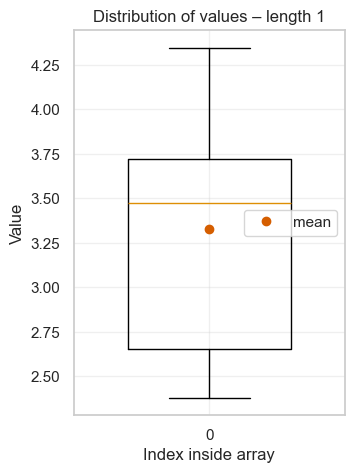

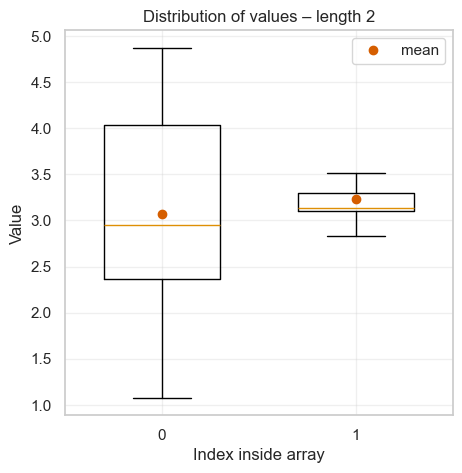

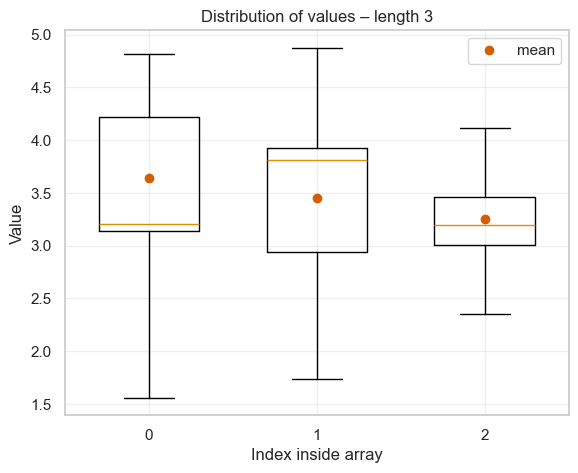

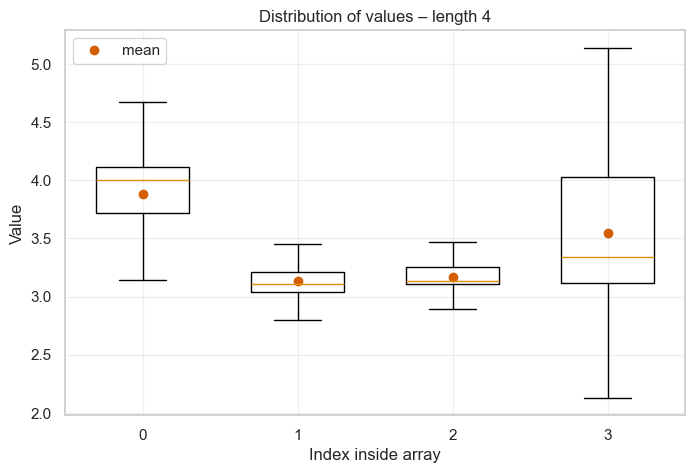

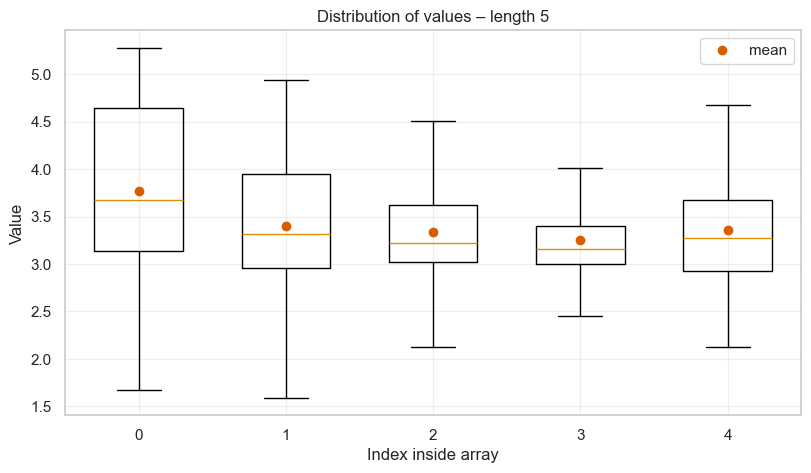

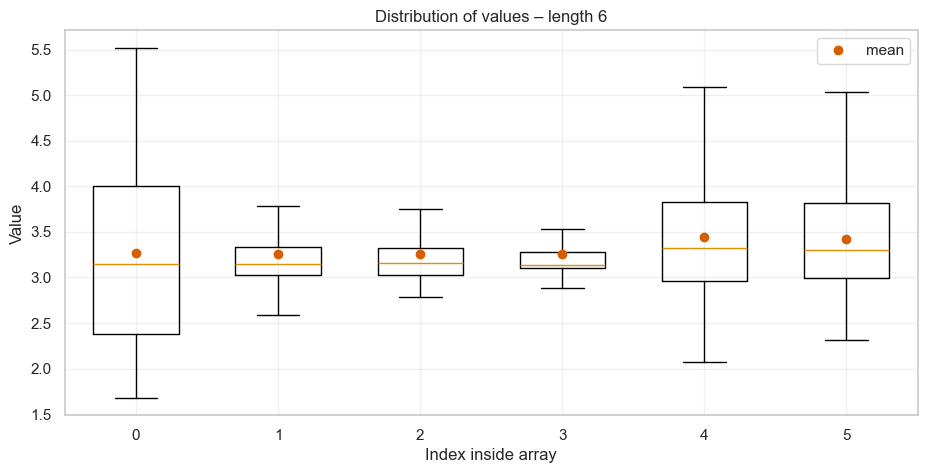

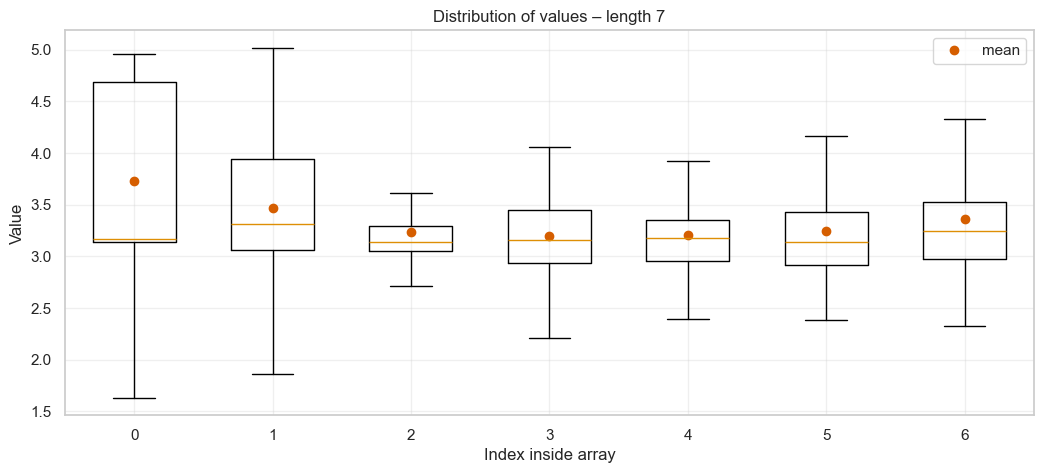

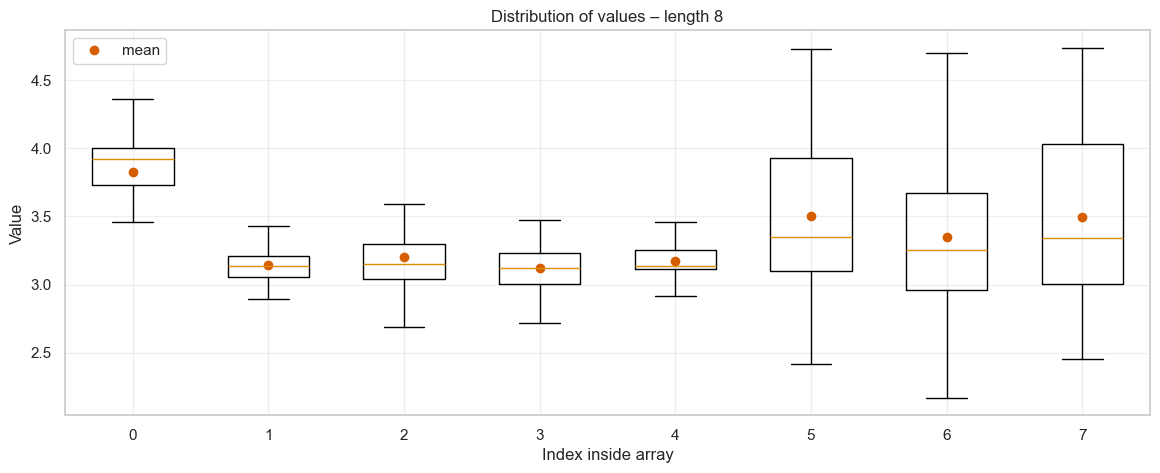

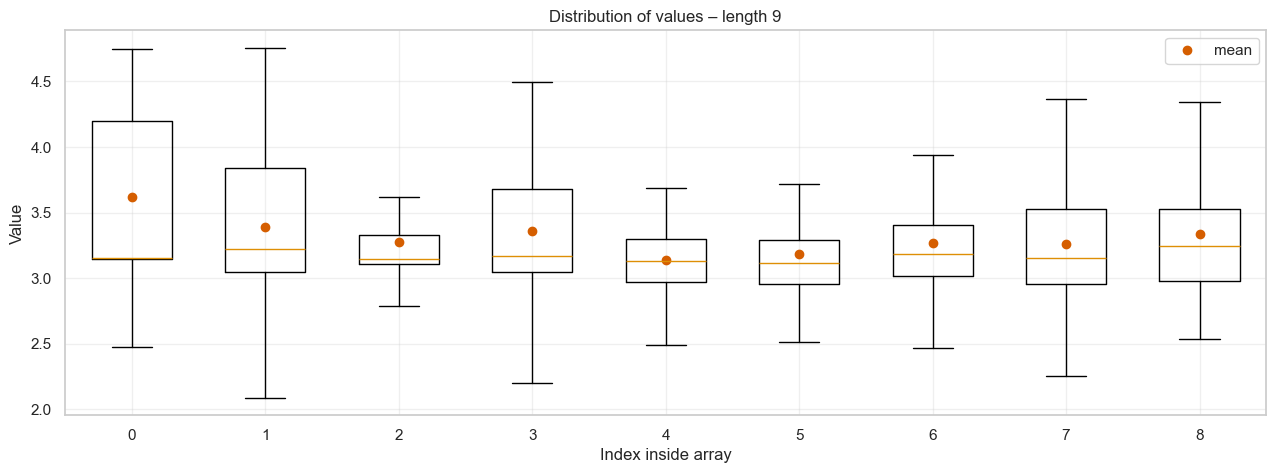

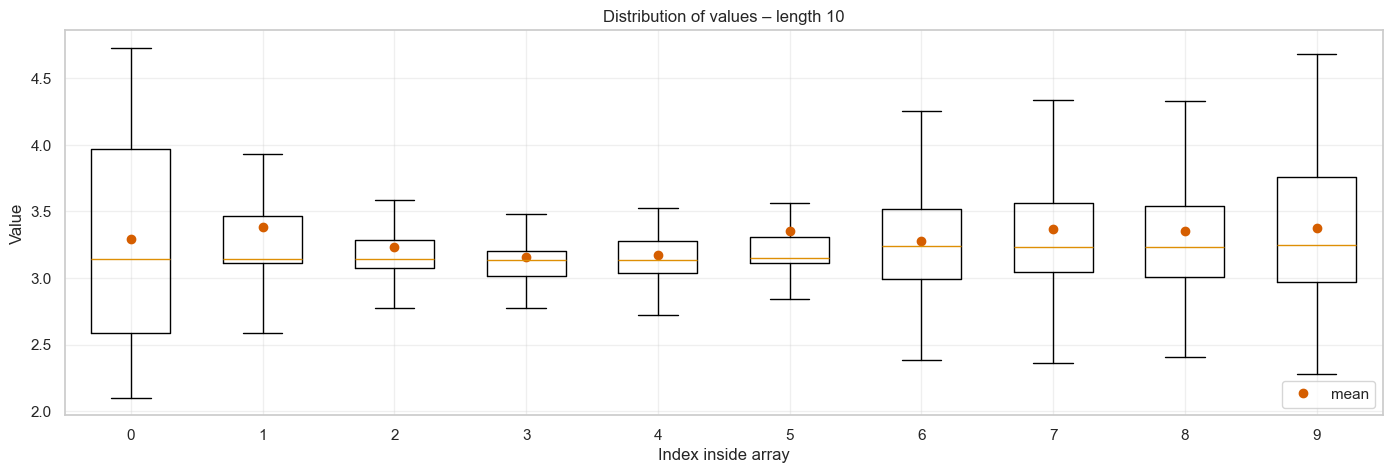

In [ ]:
combined_perfect = combined[combined['ratio'] != 1]

print(combined_perfect.groupby('depth')['ratio'].describe())
print(combined.groupby('depth').describe())
combined_perfect['param_str'] = (
    combined_perfect['final_params']
      .str.replace(r'(?<=\d)\s+(?=\d)', ',', regex=True)
)

# Display the modified 'final_params' column

import ast
import pandas as pd
import re

# Function to clean and convert string to list
def convert_to_list(x):
    try:
        if isinstance(x, str) and x != '':
            # Replace multiple spaces with a single comma
            # This regex ensures we only replace spaces between numbers, not within brackets or elsewhere
            cleaned = re.sub(r'\s+', ',', x.strip())
            # Ensure the string is properly formatted (e.g., no trailing commas)
            cleaned = cleaned.strip('[],').strip()
            # Add back the list brackets if needed
            if not cleaned.startswith('['):
                cleaned = f'[{cleaned}]'
            return ast.literal_eval(cleaned)
        return x  # Return unchanged if not a string
    except (ValueError, SyntaxError):
        print(f"Failed to parse: {x}")
        return None  # or [] if you prefer an empty list

# Apply the conversion to the 'final_params' column
combined_perfect['final_params'] = combined_perfect['final_params'].apply(convert_to_list)
# Extract gammas (even indices) and betas (odd indices)
combined_perfect['gammas'] = combined_perfect['final_params'].apply(
    lambda x: x[::2]
)

combined_perfect['betas'] = combined_perfect['final_params'].apply(
    lambda x: x[1::2]
)
import matplotlib.pyplot as plt
# Convert param_str to an array of floats
# Ensure that 'param_str' contains valid Python literals
combined_plot = combined_perfect[combined_perfect['graph_size'] == 12].copy()
plot_by_length(combined_perfect, col='gammas', lengths=(1, 2,3,4,5,6,7,8,9,10))

In [ ]:

def read_dbs(file):


    # Read the CSV file into a DataFrame
    perfect_vanilla = pd.read_csv(file)
    perfect_vanilla = perfect_vanilla[perfect_vanilla["artefact_path"].notna()]
    # Convert the 'artefact_path' column from JSON strings to dictionaries
    dict_series = perfect_vanilla["artefact_path"].apply(json.loads)

    # Normalize the JSON data into a flat DataFrame
    new_df = pd.json_normalize(dict_series)

    return new_df
some_runs = read_dbs("runs_export_cpu.csv")
most_runs = read_dbs("runs_export.csv")
print(some_runs.groupby("warm_start").count())
print(most_runs.groupby("warm_start").count())


SyntaxError: incomplete input (1909553951.py, line 17)